<a href="https://colab.research.google.com/github/Raanank10/Instagram-s-influencers/blob/Eladk_20211008/Instagram_influencers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instagram_influencers**

# Global Parameters

In [346]:
path_part0 = 'https://raw.githubusercontent.com/Raanank10/Instagram-s-influencers/main/ai_posts_analysis_data.xlsx'
fname = 'ai_posts_analysis_data.xlsx'
# fname = 'https://github.com/Raanank10/Instagram-s-influencers/blob/ai_posts_analysis_data.xlsx'
# fname = 'https://github.com/Raanank10/Instagram-s-influencers/blob/main/ai_posts_analysis_data.xlsx'

path_part1= 'https://raw.githubusercontent.com/Raanank10/Instagram-s-influencers/main/project_part1.csv'
path_part2= 'https://raw.githubusercontent.com/Raanank10/Instagram-s-influencers/main/project_part2.csv'

train_size = 0.75
rand_state = 990
sigma = 3
Min_followers = 500

In [345]:
# Bining
bin_labels=['Low','Medium','High', 'Very High','Extreme']

# Get the Data

In [218]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd
import missingno as msno
import xgboost as xgb

# SK Learn
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score , confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report # elad 20210708
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.preprocessing import OrdinalEncoder # elad 20210911

# Trees Visualization
import pydot
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO

# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# Misc
import warnings
from sys import modules
from time import time
from platform import python_version

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

# IPython
from IPython.display import Image, display

# Confuguration
warnings.filterwarnings('ignore')
%matplotlib inline

## Concate the 3 files

In [219]:
df_part0 = pd.read_csv(path_part0, index_col=0)  
print(f'data len of df_part0 = {len(df_part0)}')
df_part0.head(2)

data len of df_part0 = 4792


USERID                 USERNAME  ... VIDEO URL  VIDEO VIEW COUNT
1                                           ...                            
1918  36193140327  elastici_e_passamaneria  ...       NaN               NaN
1919   8210198494        pamela.latorre.73  ...       NaN               NaN

[2 rows x 26 columns]

In [220]:
df_part1 = pd.read_csv(path_part1, index_col=0) 
print(f'data len of df_part1 = {len(df_part1)}') 
df_part1.head(2)

data len of df_part1 = 18586


USERID  ... VIDEO VIEW COUNT
1                   ...                 
24897  47655063851  ...           1872.0
31286  47448521201  ...              NaN

[2 rows x 26 columns]

In [221]:
df_part2 = pd.read_csv(path_part2, index_col=0)  
print(f'data len of df_part2 = {len(df_part2)}') 
df_part2.head(2)

data len of df_part2 = 17471


USERID  ... VIDEO VIEW COUNT
1                   ...                 
25807  40005237207  ...              NaN
27121  17931150200  ...           3456.0

[2 rows x 26 columns]

In [222]:
df = pd.concat([df_part0, df_part1, df_part2])
print(f'data len After concat all parts = {len(df)}')

data len After concat all parts = 40849


In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40849 entries, 1918 to 37857
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   USERID                          40849 non-null  int64  
 1   USERNAME                        40849 non-null  object 
 2   FULLNAME                        39489 non-null  object 
 3   FOLLOWER                        40849 non-null  int64  
 4   POST ID                         40849 non-null  float64
 5   SHORTCODE                       40849 non-null  object 
 6   LIKES                           40849 non-null  int64  
 7   COMMENTS                        40849 non-null  int64  
 8   ENGAGEMENT                      40849 non-null  float64
 9   URL                             40849 non-null  object 
 10  ACCESSIBILITY CAPTION           33725 non-null  object 
 11  CAPTION                         34786 non-null  object 
 12  LOCATION                     

In [224]:
print(f'data len Before = {len(df)}')
df = df[~df.index.duplicated()]
print(f'data len After  = {len(df)}')
df.info()

data len Before = 40849
data len After  = 36057
<class 'pandas.core.frame.DataFrame'>
Int64Index: 36057 entries, 1918 to 37857
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   USERID                          36057 non-null  int64  
 1   USERNAME                        36057 non-null  object 
 2   FULLNAME                        34823 non-null  object 
 3   FOLLOWER                        36057 non-null  int64  
 4   POST ID                         36057 non-null  float64
 5   SHORTCODE                       36057 non-null  object 
 6   LIKES                           36057 non-null  int64  
 7   COMMENTS                        36057 non-null  int64  
 8   ENGAGEMENT                      36057 non-null  float64
 9   URL                             36057 non-null  object 
 10  ACCESSIBILITY CAPTION           29782 non-null  object 
 11  CAPTION                         30476 non-

In [225]:
print(f'data len Before = {len(df)}')
df = df[df.FOLLOWER >= Min_followers]
print(f'data len Before = {len(df)}')
df.info()

data len Before = 36057
data len Before = 22123
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22123 entries, 1918 to 37546
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   USERID                          22123 non-null  int64  
 1   USERNAME                        22123 non-null  object 
 2   FULLNAME                        21598 non-null  object 
 3   FOLLOWER                        22123 non-null  int64  
 4   POST ID                         22123 non-null  float64
 5   SHORTCODE                       22123 non-null  object 
 6   LIKES                           22123 non-null  int64  
 7   COMMENTS                        22123 non-null  int64  
 8   ENGAGEMENT                      22123 non-null  float64
 9   URL                             22123 non-null  object 
 10  ACCESSIBILITY CAPTION           17756 non-null  object 
 11  CAPTION                         20146 non-

# EDA

Column names: Replace white spaces with underscore 

In [226]:
df.columns = df.columns.str.replace(' ', '_')

Check for each column how many unique is there (lenght of the dataset 4792, len(df)) 

In [227]:
df.apply(lambda col: len(col.unique())).sort_values(ascending=False)

IMAGE_URL                         22123
SHORTCODE                         22075
URL                               22075
TIME                              22059
IMAGE_LABELS                      21317
CAPTION                           19283
ACCESSIBILITY_CAPTION             17077
VIDEO_URL                          4094
POST_ID                            3786
LOCATION                           3475
ENGAGEMENT                         2500
FULLNAME                           1975
CITY                               1955
USERNAME                           1947
USERID                             1947
FOLLOWER                           1571
LIKES                              1530
VIDEO_VIEW_COUNT                   1501
COMMENTS                            312
COUNTRY                             106
CAPTION_INTEREST                     37
IMAGE_LABEL_INTEREST                 36
ACCESSIBILITY_CAPTION_INTEREST       31
COMMENT_DISABLED                      2
IS_VIDEO                              2


## Data Cleaning

In [228]:
# Descriptive statistics for each column
df.describe()

USERID      FOLLOWER  ...          TIME  VIDEO_VIEW_COUNT
count  2.212300e+04  2.212300e+04  ...  2.212300e+04      4.093000e+03
mean   1.294732e+10  5.353148e+04  ...  1.619499e+09      1.448958e+04
std    1.635346e+10  1.011282e+06  ...  2.029269e+07      2.316489e+05
min    3.142160e+05  5.000000e+02  ...  1.388331e+09      0.000000e+00
25%    5.652381e+08  9.180000e+02  ...  1.619573e+09      9.400000e+01
50%    4.459829e+09  1.616000e+03  ...  1.624838e+09      2.350000e+02
75%    2.290415e+10  4.140000e+03  ...  1.630711e+09      7.290000e+02
max    4.944817e+10  3.636130e+07  ...  1.632341e+09      9.785071e+06

[8 rows x 8 columns]

In [229]:
df.isnull().sum()

USERID                                0
USERNAME                              0
FULLNAME                            525
FOLLOWER                              0
POST_ID                               0
SHORTCODE                             0
LIKES                                 0
COMMENTS                              0
ENGAGEMENT                            0
URL                                   0
ACCESSIBILITY_CAPTION              4367
CAPTION                            1977
LOCATION                          14635
CITY                              15128
COUNTRY                           15980
TIME                                  0
IMAGE_LABELS                         14
CAPTION_INTEREST                   1977
ACCESSIBILITY_CAPTION_INTEREST     4367
IMAGE_LABEL_INTEREST                 14
IMAGE_URL                             0
COMMENT_DISABLED                      0
IS_VIDEO                              0
HAS_AUDIO                             0
VIDEO_URL                         18030


In [230]:
print(f'data len Before = {len(df)}')
df = df[df['ENGAGEMENT'].notna()]
print(f'data len After  = {len(df)}')

data len Before = 22123
data len After  = 22123


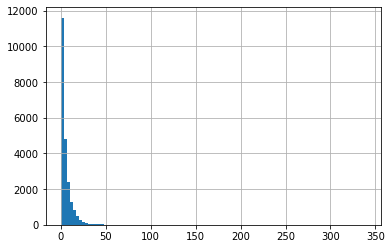

In [231]:
df.ENGAGEMENT.hist(bins=100)

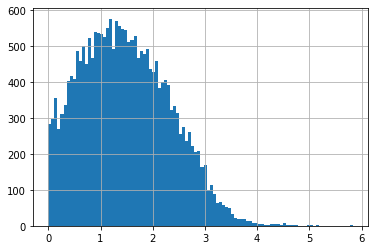

In [232]:
log_ENGAGEMENT = np.log1p(df.ENGAGEMENT)
log_ENGAGEMENT.hist(bins=100)

In [233]:
df['log_ENGAGEMENT'] = log_ENGAGEMENT

In [234]:
print(f'data len Before = {len(df)}')
df = df[df['LIKES'].notna()]
print(f'data len After  = {len(df)}')

data len Before = 22123
data len After  = 22123


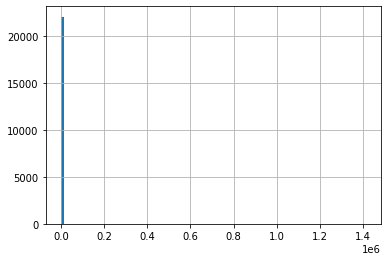

In [235]:
df.LIKES.hist(bins=100)

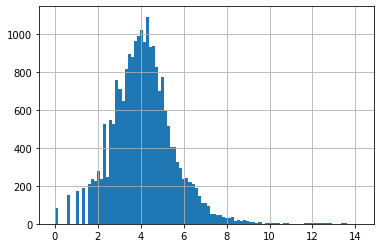

In [236]:
log_LIKES = np.log1p(df.LIKES)
log_LIKES.hist(bins=100)

In [237]:
df['log_LIKES'] = log_LIKES

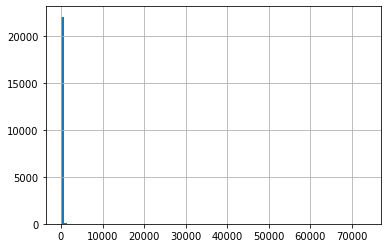

In [238]:
df.COMMENTS.hist(bins=100)

In [239]:
print(f'data len Before = {len(df)}')
df = df[df['COMMENTS'].notna()]
print(f'data len After  = {len(df)}')

data len Before = 22123
data len After  = 22123


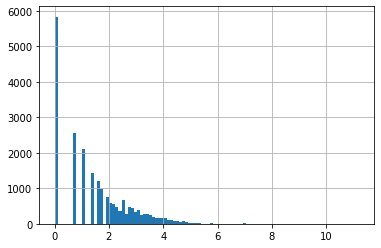

In [240]:
log_COMMENTS = np.log1p(df.COMMENTS)
log_COMMENTS.hist(bins=100)

In [241]:
df['log_COMMENTS'] = log_COMMENTS

##Feature Engeering - Unstack IMAGE_LABELS, 

Eladk 7-Oct-2021

In [242]:
df['IMAGE_LABELS'].unique()

array(['Clothing, Apparel, Text, Money, Collage, Advertisement, Poster',
       'Clothing, Apparel, Person, Human, Female, Swimwear, Footwear, Woman, Bikini, Shoe, Skin, Pants, Flooring, Girl',
       'Clothing, Apparel, Person, Human, Sunglasses, Accessories, Accessory, Face, Scarf, Portrait, Photography, Photo, Glasses, People, Selfie, Female, Coat, Smile',
       ...,
       'Coin, Money, Gold, Flyer, Advertisement, Paper, Poster, Brochure',
       'Nature, Outdoors, Sky, Azure Sky, Horizon, Ice',
       'Face, Person, Human, Female, Plant, Tree, Clothing, Apparel, Woman, Portrait, Photography, Photo, Girl, Palm Tree, Arecaceae, Smile, Selfie, Glasses, Accessories, Accessory, Laughing'],
      dtype=object)

In [243]:
df['CAPTION_INTEREST'].unique()

array(['education', nan, 'entertainment', 'desserts_baking',
       'dating_and_relationships', 'arts_entertainment', 'business',
       'gaming', 'travel', 'news', 'music', 'politics', 'pets',
       'food_drink', 'parenting', 'style_fashion', 'humor', 'sports',
       'accessories', 'technology_computing', 'health', 'home_garden',
       'weddings', 'books_literature', 'legal', 'movies', 'fitness',
       'chef', 'events', 'baking_cooking', 'comic_books',
       'cars_motorcycles', 'hobbies_interests', 'podcasts',
       'green_living', 'barbecues_grilling', 'finance'], dtype=object)

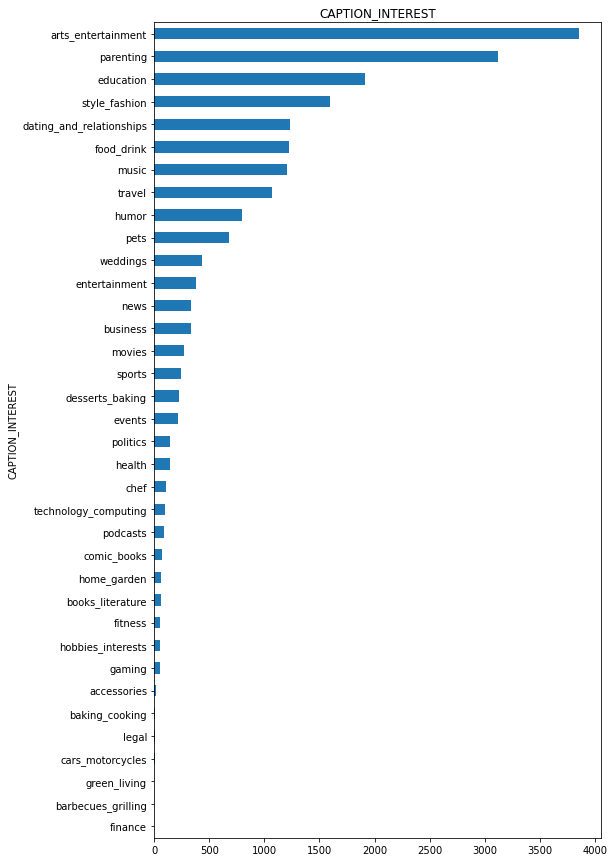

In [244]:
IMAGE_LABELS = df.groupby('CAPTION_INTEREST').size().sort_values()
IMAGE_LABELS.plot.barh(figsize=(8, 15), fontsize=10, title='CAPTION_INTEREST')

Ealdk Oct-5 this execution taks 19 minutes, so i remarked it

In [245]:
# IMAGE_LABELS = df.groupby('IMAGE_LABELS').size().sort_values()
# IMAGE_LABELS.plot.barh(figsize=(8, 15), fontsize=10, title='IMAGE_LABELS')

## Sigma cleaning

In [246]:
# # we lose the most viral posts and most unviral posts
# for col in df.columns:
#     if df[col].dtype == 'float64':
#         std = df[col].std()
#         ave = df[col].mean()
#         df = df.loc[df[col].between\
#                                (ave - (sigma * std), ave + (sigma * std))] 
#         print(f'Processing {col:10} --> {df.shape[0]:5} entities entries remain')

In [247]:
df.describe()

USERID      FOLLOWER  ...     log_LIKES  log_COMMENTS
count  2.212300e+04  2.212300e+04  ...  22123.000000  22123.000000
mean   1.294732e+10  5.353148e+04  ...      4.117498      1.515258
std    1.635346e+10  1.011282e+06  ...      1.445193      1.335125
min    3.142160e+05  5.000000e+02  ...      0.000000      0.000000
25%    5.652381e+08  9.180000e+02  ...      3.178054      0.000000
50%    4.459829e+09  1.616000e+03  ...      4.060443      1.386294
75%    2.290415e+10  4.140000e+03  ...      4.919981      2.397895
max    4.944817e+10  3.636130e+07  ...     14.158911     11.200800

[8 rows x 11 columns]

How Many NaN values are ther in the datast?

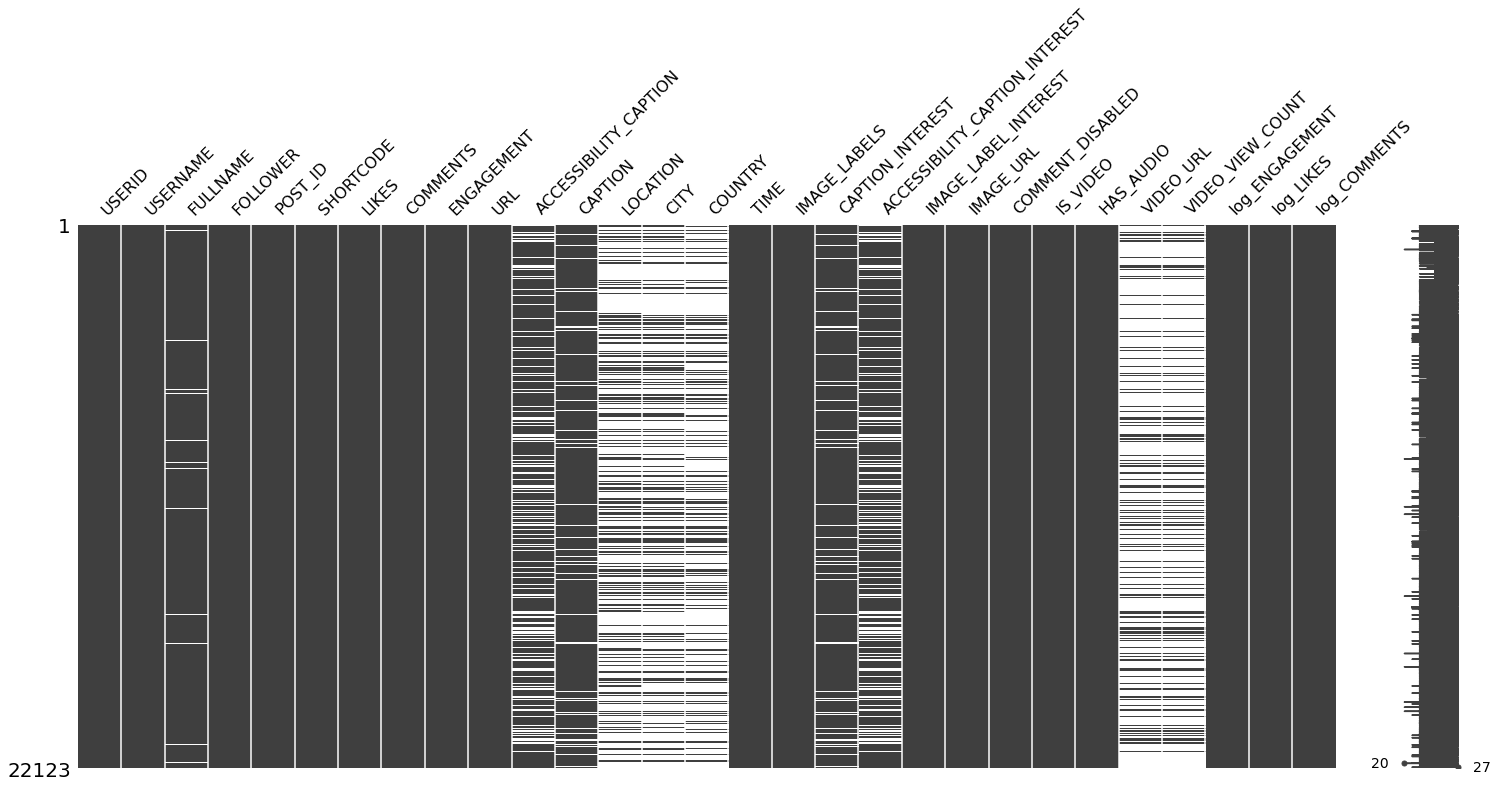

In [248]:
msno.matrix(df)

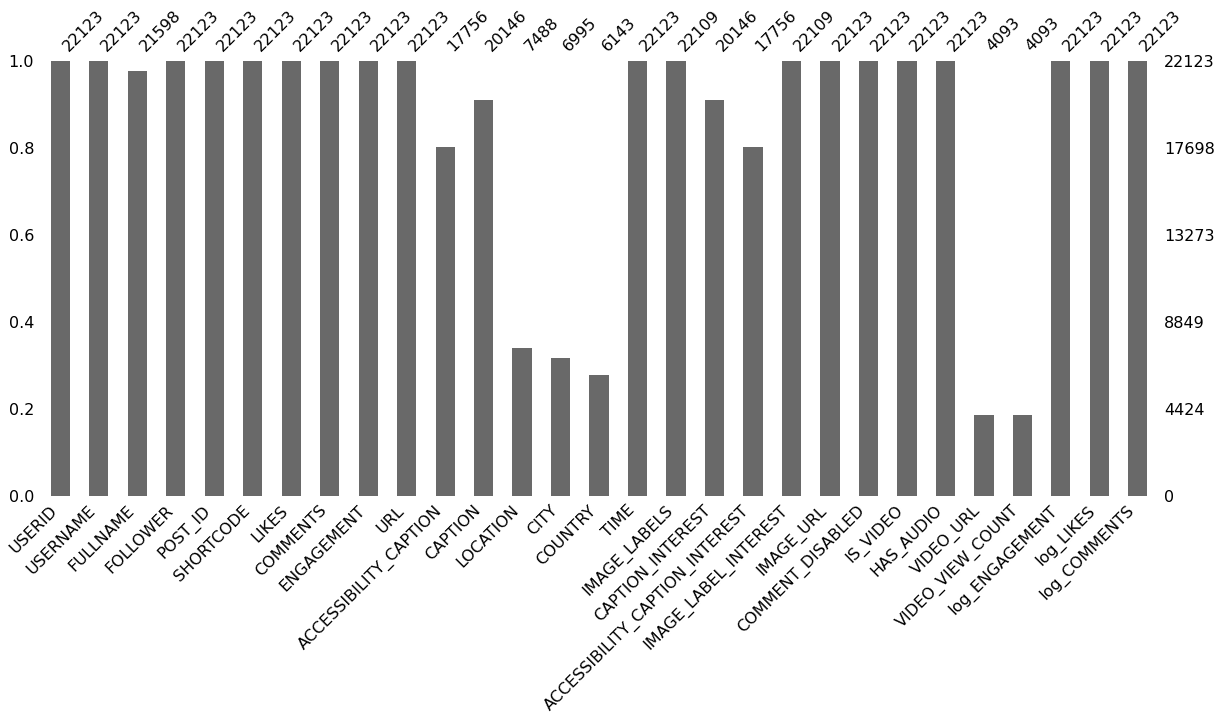

In [249]:
msno.bar(df, figsize=(20, 8))

Conert unix time to separate Date and Time columns

In [250]:
df['DATETIME'] = pd.to_datetime(df['TIME'],unit='s')

In [251]:
df['YEAR'] = pd.DatetimeIndex(df['DATETIME']).year
df['MONTH'] = pd.DatetimeIndex(df['DATETIME']).month
df['DAY'] = pd.DatetimeIndex(df['DATETIME']).day
df['DAYOFWEEK'] = pd.DatetimeIndex(df['DATETIME']).dayofweek
df['HOUR'] = pd.DatetimeIndex(df['DATETIME']).hour
df['MINUTE'] = pd.DatetimeIndex(df['DATETIME']).minute

## Some Data Visualization (mostly on time)

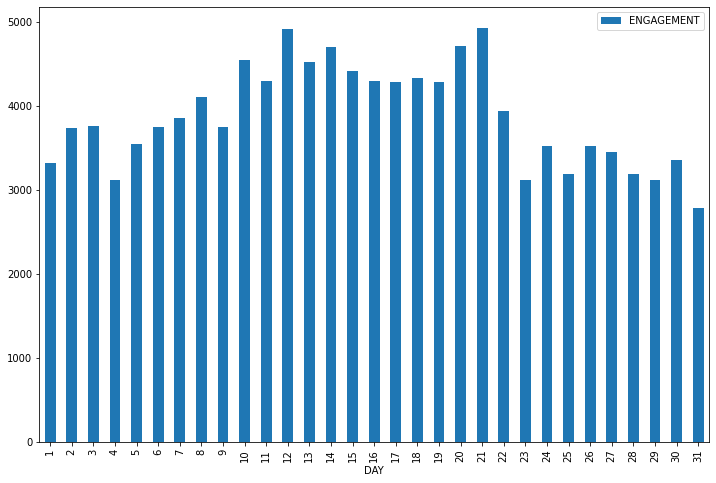

In [252]:
per_DAY = df.groupby(['DAY']).sum()
per_DAY.plot(y=["ENGAGEMENT"], kind="bar",figsize=(12,8))

In [253]:
df.columns

Index(['USERID', 'USERNAME', 'FULLNAME', 'FOLLOWER', 'POST_ID', 'SHORTCODE',
       'LIKES', 'COMMENTS', 'ENGAGEMENT', 'URL', 'ACCESSIBILITY_CAPTION',
       'CAPTION', 'LOCATION', 'CITY', 'COUNTRY', 'TIME', 'IMAGE_LABELS',
       'CAPTION_INTEREST', 'ACCESSIBILITY_CAPTION_INTEREST',
       'IMAGE_LABEL_INTEREST', 'IMAGE_URL', 'COMMENT_DISABLED', 'IS_VIDEO',
       'HAS_AUDIO', 'VIDEO_URL', 'VIDEO_VIEW_COUNT', 'log_ENGAGEMENT',
       'log_LIKES', 'log_COMMENTS', 'DATETIME', 'YEAR', 'MONTH', 'DAY',
       'DAYOFWEEK', 'HOUR', 'MINUTE'],
      dtype='object')

In [254]:
df.LIKES

1
1918      23
1920     138
1922      46
1929      50
1930     102
        ... 
35893      0
35916      0
36397      2
36489      0
37546      0
Name: LIKES, Length: 22123, dtype: int64

NUM_OF_LIKES  ...  NUM_OF_LIKES_IN_THOUSANDS
DAYOFWEEK                ...                           
0               5250878  ...                   5250.878
1               5030212  ...                   5030.212
2               1468106  ...                   1468.106
3               2519352  ...                   2519.352
4               3071985  ...                   3071.985
5               1007566  ...                   1007.566
6               4041097  ...                   4041.097

[7 rows x 4 columns]

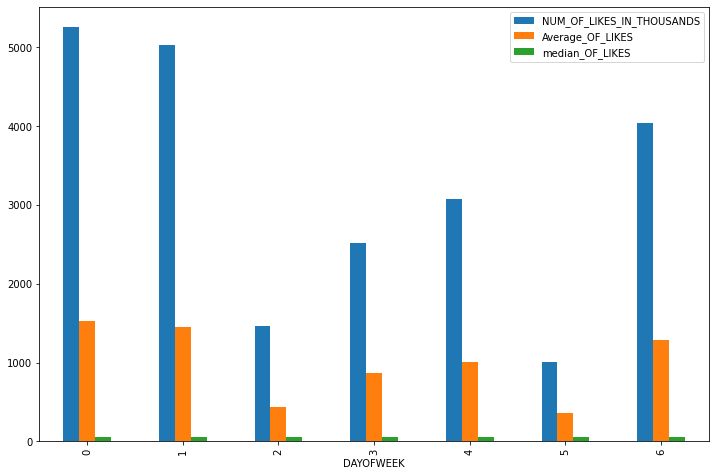

In [255]:
per_DAYOFWEEK = df.groupby('DAYOFWEEK').agg(NUM_OF_LIKES=('LIKES','sum'),
                                            Average_OF_LIKES=('LIKES','mean'),
                                            median_OF_LIKES=('LIKES','median')
                                            )

per_DAYOFWEEK["NUM_OF_LIKES_IN_THOUSANDS"] = per_DAYOFWEEK['NUM_OF_LIKES']/1000
per_DAYOFWEEK.plot(y=["NUM_OF_LIKES_IN_THOUSANDS",
                      "Average_OF_LIKES","median_OF_LIKES"], kind="bar",figsize=(12,8))
per_DAYOFWEEK

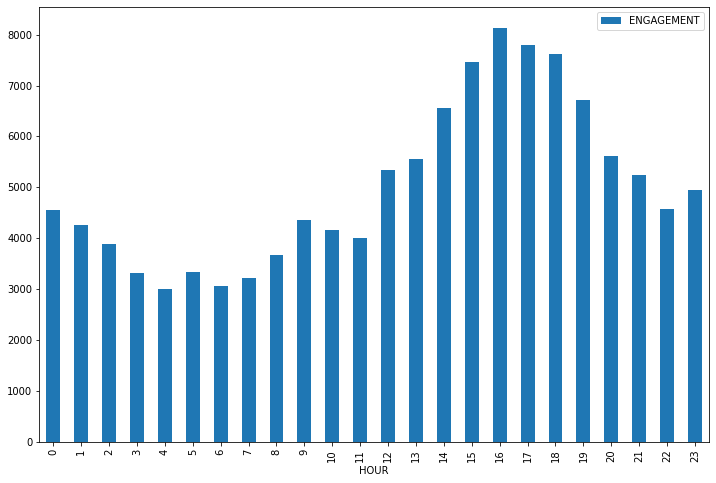

In [256]:
per_HOUR = df.groupby(['HOUR']).sum()
per_HOUR.plot(y=["ENGAGEMENT"], kind="bar",figsize=(12,8))

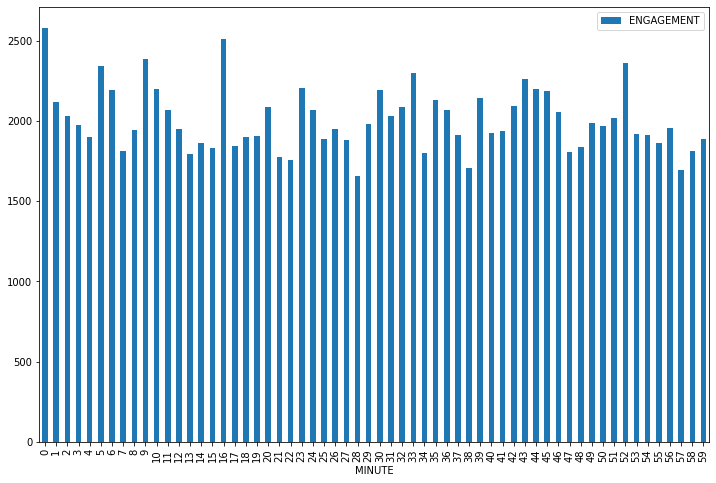

In [257]:
per_MINUTE = df.groupby(['MINUTE']).sum()
per_MINUTE.plot(y=["ENGAGEMENT"], kind="bar",figsize=(12,8))

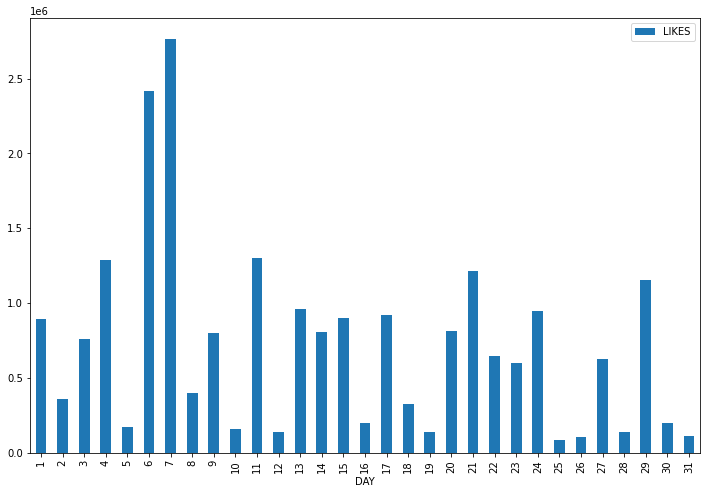

In [258]:
per_DAY = df.groupby(['DAY']).sum()
per_DAY.plot(y=["LIKES"], kind="bar",figsize=(12,8))

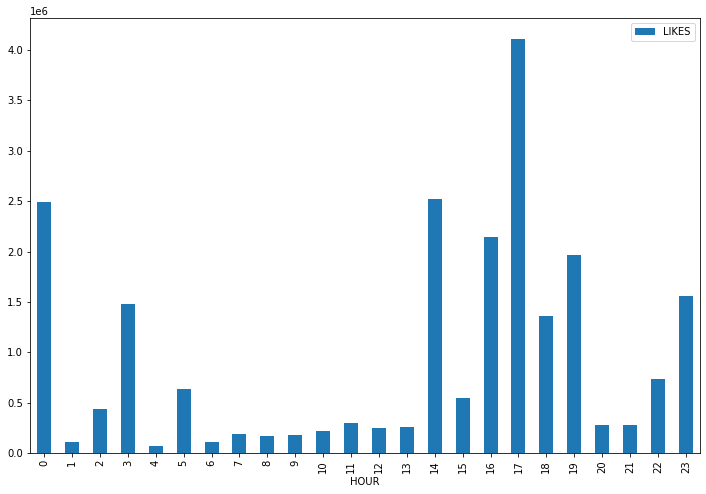

In [259]:
per_HOUR = df.groupby(['HOUR']).sum()
per_HOUR.plot(y=["LIKES"], kind="bar",figsize=(12,8))

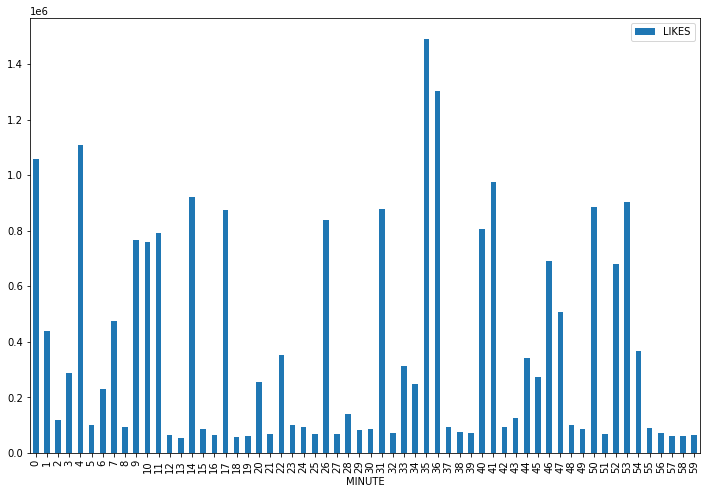

In [260]:
per_MINUTE = df.groupby(['MINUTE']).sum()
per_MINUTE.plot(y=["LIKES"], kind="bar",figsize=(12,8))

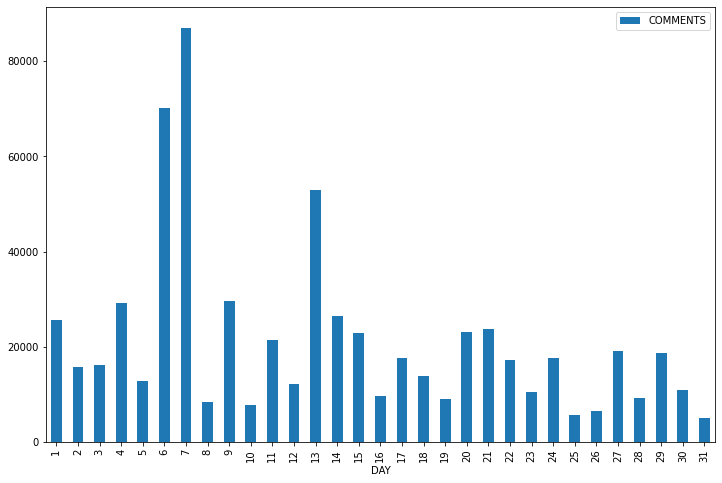

In [261]:
per_DAY = df.groupby(['DAY']).sum()
per_DAY.plot(y=["COMMENTS"], kind="bar",figsize=(12,8))

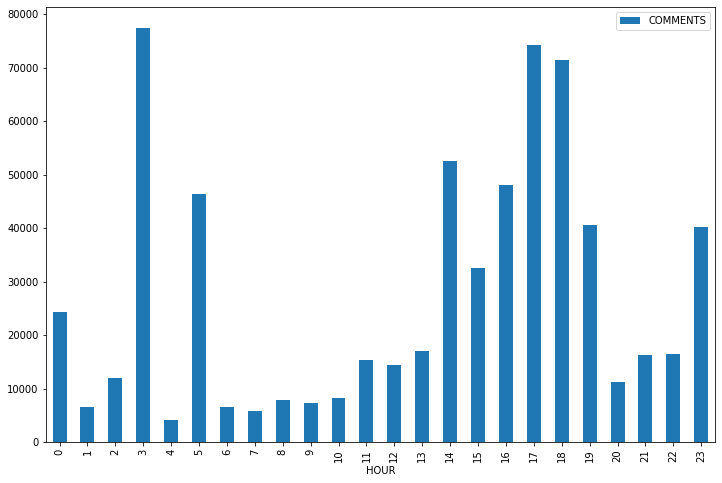

In [262]:
per_HOUR = df.groupby(['HOUR']).sum()
per_HOUR.plot(y=["COMMENTS"], kind="bar",figsize=(12,8))

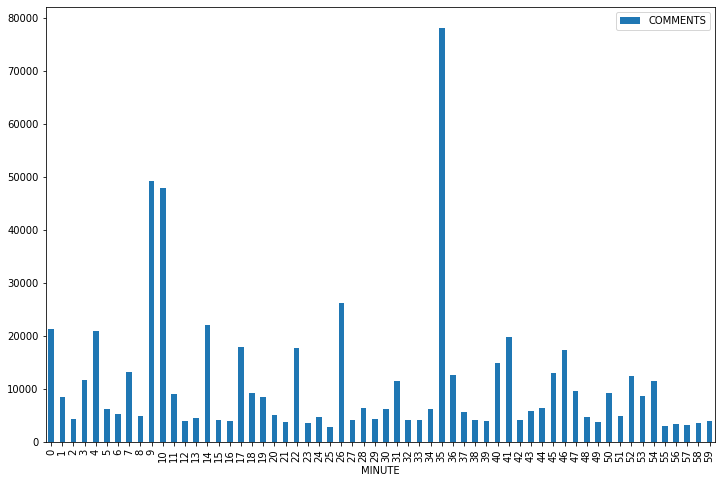

In [263]:
per_MINUTE = df.groupby(['MINUTE']).sum()
per_MINUTE.plot(y=["COMMENTS"], kind="bar",figsize=(12,8))

In [264]:
# per_FULLNAME = df.groupby(['USERNAME']).sum()
# per_FULLNAME.plot(y=["ENGAGEMENT", "LIKES","COMMENTS"], kind="bar",figsize=(12,8))

# plt.title("Total ENGAGEMENT, LIKES, COMMENTS per state",fontsize=15)
# plt.xlabel('FULLNAME',fontsize=12)
# plt.ylabel('ENGAGEMENT, LIKES, COMMENTS',fontsize=12)

Remove column that all values are unique:

In [265]:
for col in df.columns:
    if len(df[col].unique()) == len(df):
        print(col)
        #df.drop(col,inplace=True,axis=1)

IMAGE_URL


In [266]:
df.head()

USERID                 USERNAME  ... HOUR  MINUTE
1                                           ...             
1918  36193140327  elastici_e_passamaneria  ...   10      39
1920  36838177086              ilaria._004  ...   19      54
1922   5633363536                 amineblc  ...    0      15
1929    555815104           vittoria_caron  ...   11      44
1930   2727935277            mr_artworker_  ...   18       5

[5 rows x 36 columns]

In [267]:
df.URL.head()
# SHORTCODE
# URL
# IMAGE_URL
# VIDEO_URL # Not working

1
1918    https://www.instagram.com/p/CMegChUlwm2
1920    https://www.instagram.com/p/CCy784yAY26
1922    https://www.instagram.com/p/B2Fuq_ylPo_
1929    https://www.instagram.com/p/CH5E6XPDO_y
1930    https://www.instagram.com/p/CPQ93T1FJfN
Name: URL, dtype: object

## creating new columns for featur engeneering base on the columns of CAPTION ,ACCESSIBILITY_CAPTION, IMAGE_LABELS :

new columns for featur engeneering for 'CAPTION','ACCESSIBILITY_CAPTION','IMAGE_LABELS':
*   Number of Hash # in 'CAPTION','ACCESSIBILITY_CAPTION','IMAGE_LABELS',
*   Number of AT @ in CAPTION
*   Number of question mark? in CAPTION
*   Number of , in CAPTION
*   Number of Words in CAPTION

7-Oct

In [268]:
#count number of !
#df['exc'] = df['line'].map(lambda x: x.count("!"))

In [269]:
d = pd.DataFrame(df[df.index == 2728].CAPTION)

In [270]:
#Number of Words in CAPTION:
#d['NUMBER_OF_WORDS_IN_CAPTION'] = [len(x.split()) for x in df[df.index == 2728].CAPTION.tolist()]
#d['words'] = [len(x.split()) for x in d['CAPTION'].tolist()]
#df['NUMBER_OF_WORDS_IN_CAPTION'] = [len(x.split()) for x in df['CAPTION'].tolist()]

Sampleing:

In [271]:
num_of_samples = 5
list_of_sample_index = list((df.URL.sample(num_of_samples).index.values))
print('indesc sample are: ', list_of_sample_index)
print(df.loc[list_of_sample_index]['URL'])
df.loc[list_of_sample_index][['LIKES','CAPTION','ACCESSIBILITY_CAPTION','IMAGE_LABELS','CAPTION_INTEREST', 'ACCESSIBILITY_CAPTION_INTEREST','IMAGE_LABEL_INTEREST'
,'FOLLOWER','LOCATION'
]]

indesc sample are:  [32268, 11278, 14677, 28372, 11333]
1
32268    https://www.instagram.com/p/CT4nqpQgADj
11278    https://www.instagram.com/p/CTKMpR7rODn
14677    https://www.instagram.com/p/CUDlqCOjyEp
28372    https://www.instagram.com/p/CPWDoCOgiBq
11333    https://www.instagram.com/p/CUD3e3TtAZ5
Name: URL, dtype: object


LIKES  ...                  LOCATION
1             ...                          
32268    139  ...         Fortaleza, Brazil
11278    104  ...                       NaN
14677     45  ...                       NaN
28372     18  ...  Caracas, D.F., Venezuela
11333    946  ...                       NaN

[5 rows x 9 columns]

## Remove unneccessary columns from Dataframe

In [272]:
df.drop(['POST_ID','VIDEO_URL','SHORTCODE','IMAGE_URL','USERID','FULLNAME','USERNAME',
         'USERID','TIME',#'URL',
         'VIDEO_VIEW_COUNT'],inplace=True,axis=1)

After talking with Royi on 1-Oct: 

In [273]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22123 entries, 1918 to 37546
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   FOLLOWER                        22123 non-null  int64         
 1   LIKES                           22123 non-null  int64         
 2   COMMENTS                        22123 non-null  int64         
 3   ENGAGEMENT                      22123 non-null  float64       
 4   URL                             22123 non-null  object        
 5   ACCESSIBILITY_CAPTION           17756 non-null  object        
 6   CAPTION                         20146 non-null  object        
 7   LOCATION                        7488 non-null   object        
 8   CITY                            6995 non-null   object        
 9   COUNTRY                         6143 non-null   object        
 10  IMAGE_LABELS                    22109 non-null  object        
 11 

Convert columns type to characters :

In [274]:
df['COMMENT_DISABLED'].value_counts()

no     21990
yes      133
Name: COMMENT_DISABLED, dtype: int64

In [275]:
df['COMMENT_DISABLED'] = df['COMMENT_DISABLED'].map(dict(yes=1, no=0))

In [276]:
df['IS_VIDEO'] = df['IS_VIDEO'].map(dict(yes=1, no=0))

In [277]:
df['HAS_AUDIO'] = df['HAS_AUDIO'].map(dict(yes=1, no=0))

In [278]:
df[['COMMENT_DISABLED','IS_VIDEO','HAS_AUDIO']].value_counts()

COMMENT_DISABLED  IS_VIDEO  HAS_AUDIO
0                 0         0            17929
                  1         1             3787
                            0              274
1                 0         0              101
                  1         1               26
                            0                6
dtype: int64

In [279]:
pd.unique(df[['COMMENT_DISABLED','IS_VIDEO','HAS_AUDIO']].values.ravel('K'))

array([0, 1])

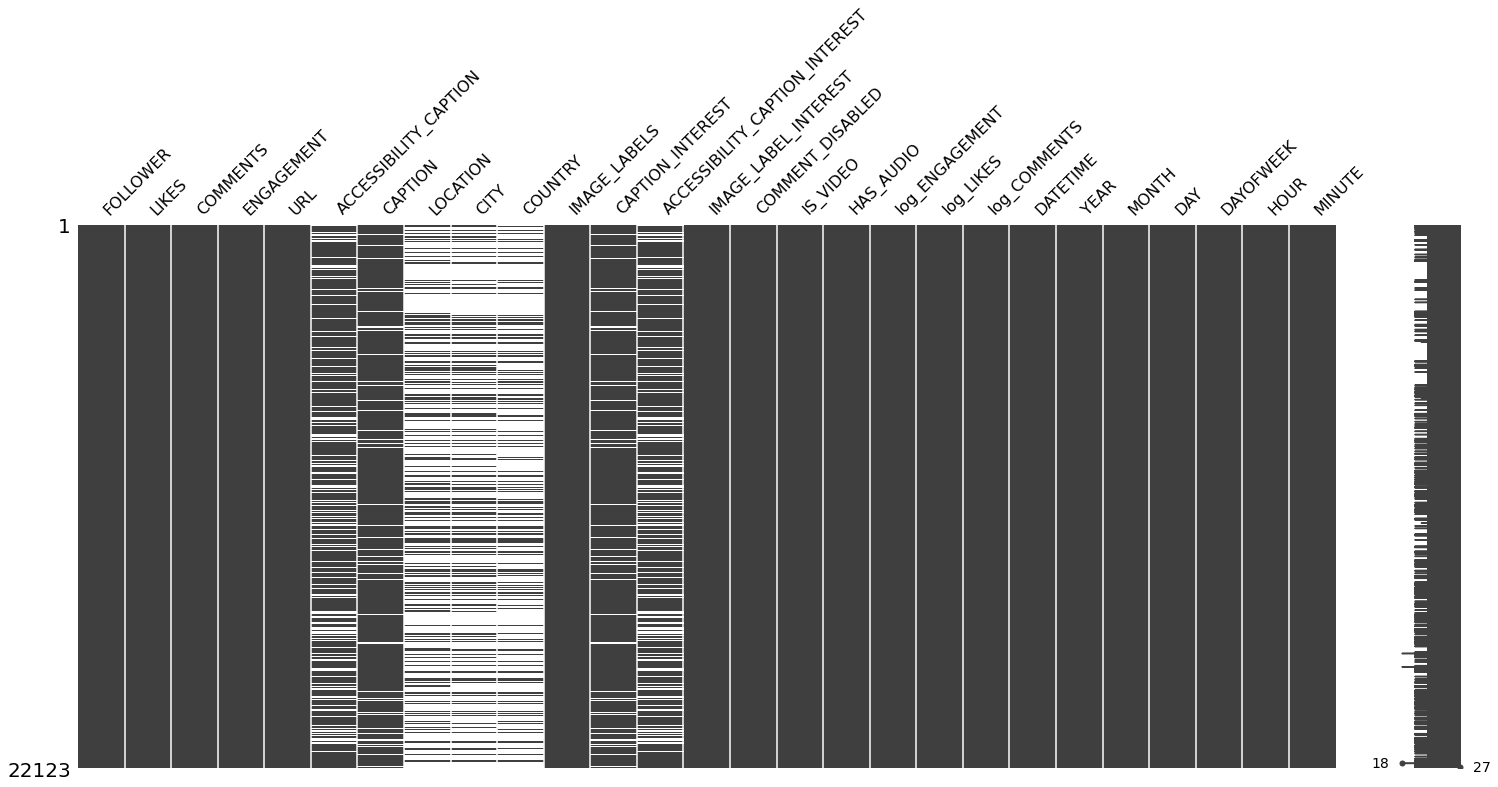

In [280]:
msno.matrix(df)

In [281]:
df.columns

Index(['FOLLOWER', 'LIKES', 'COMMENTS', 'ENGAGEMENT', 'URL',
       'ACCESSIBILITY_CAPTION', 'CAPTION', 'LOCATION', 'CITY', 'COUNTRY',
       'IMAGE_LABELS', 'CAPTION_INTEREST', 'ACCESSIBILITY_CAPTION_INTEREST',
       'IMAGE_LABEL_INTEREST', 'COMMENT_DISABLED', 'IS_VIDEO', 'HAS_AUDIO',
       'log_ENGAGEMENT', 'log_LIKES', 'log_COMMENTS', 'DATETIME', 'YEAR',
       'MONTH', 'DAY', 'DAYOFWEEK', 'HOUR', 'MINUTE'],
      dtype='object')

Raname the index

In [282]:
df = df.rename_axis('LINE_NUM_INDEX')

Note by Eladk: we can fill location values by using a merdiction model base in the influancer and the time for the post. <BR> 
For Now, I'll just fill the columns with NULL

Replace all cases where VIDEO_VIEW_COUNT == Nan with 0. <BR> for double check i verified it with is_video column

Eladk note 8-Sep-2021: I still need to handle missing values in column:


*   FULLNAME
*   ACCESSIBILITY_CAPTION - specify full name, time, location, video or picture and tag
*   CAPTION - the text on this post (by the post uploader
*   LOCATION, CITY, COUNTRY - location
*   CAPTION_INTEREST -
*   ACCESSIBILITY_CAPTION_INTEREST


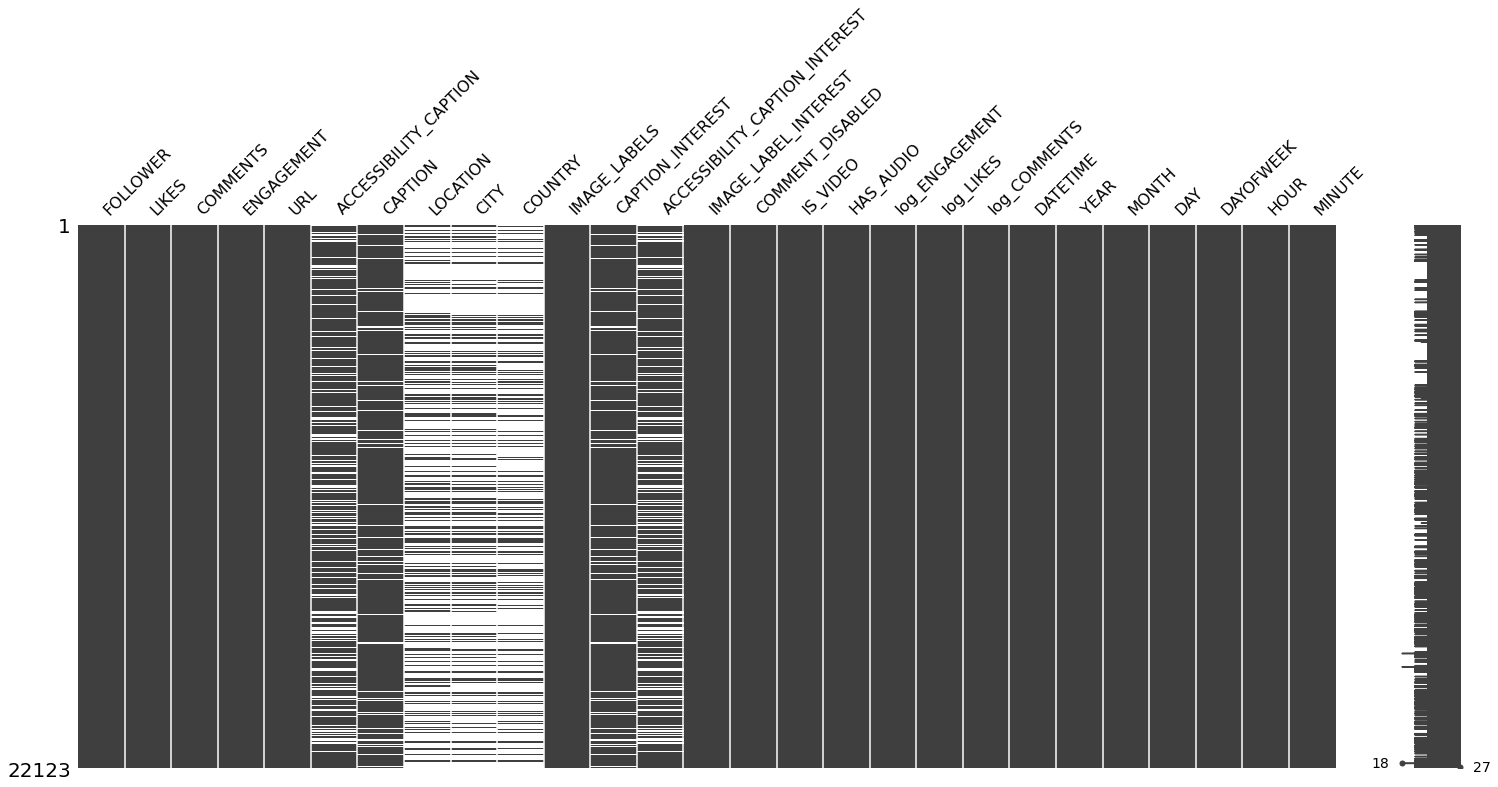

In [283]:
msno.matrix(df)

In [284]:
df.CAPTION.value_counts().sort_values(ascending=False)

????                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   179
????????                                                                                                                                                                                                                                                                                                                     

selecting a subset of the data:

In [285]:
df[['ACCESSIBILITY_CAPTION','CAPTION','LOCATION', 'CITY', 'COUNTRY'\
    ,'CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']].head(5)

ACCESSIBILITY_CAPTION  ... ACCESSIBILITY_CAPTION_INTEREST
LINE_NUM_INDEX                                                                                                                                        ...                               
1918                                                                                             Photo by Elastici e Passamaneria on March 16, 2021.  ...                         movies
1920                                                                        Photo by ???????????????? on July 18, 2020. May be an image of 1 person.  ...             arts_entertainment
1922                                                                                                             Photo by Mohamed Amine in Mawazine.  ...                           news
1929            Photo by V i t t o r i a   C a r o n in Palermo, Italy with @federico_alberti_. May be an image of 2 people, outerwear and monument.  ...                          music
1930                                                                                                                                             NaN  ...                            NaN

[5 rows x 7 columns]

Increase the length to a column so that we'll see all the text in a cell

In [286]:
pd.options.display.max_colwidth = 1000
df.ACCESSIBILITY_CAPTION.head(5)

LINE_NUM_INDEX
1918                                                                                     Photo by Elastici e Passamaneria on March 16, 2021.
1920                                                                Photo by ???????????????? on July 18, 2020. May be an image of 1 person.
1922                                                                                                     Photo by Mohamed Amine in Mawazine.
1929    Photo by V i t t o r i a   C a r o n in Palermo, Italy with @federico_alberti_. May be an image of 2 people, outerwear and monument.
1930                                                                                                                                     NaN
Name: ACCESSIBILITY_CAPTION, dtype: object

Selecting 1 row by index (specific column only)

In [287]:
#df[df.index == 1929][['URL','ACCESSIBILITY_CAPTION','DATETIME','LOCATION']] # name, 
df[df.index == 1929][['ACCESSIBILITY_CAPTION','DATETIME','LOCATION']] # name, 

ACCESSIBILITY_CAPTION  ...        LOCATION
LINE_NUM_INDEX                                                                                                                                        ...                
1929            Photo by V i t t o r i a   C a r o n in Palermo, Italy with @federico_alberti_. May be an image of 2 people, outerwear and monument.  ...  Palermo, Italy

[1 rows x 3 columns]

In [288]:
df.columns

Index(['FOLLOWER', 'LIKES', 'COMMENTS', 'ENGAGEMENT', 'URL',
       'ACCESSIBILITY_CAPTION', 'CAPTION', 'LOCATION', 'CITY', 'COUNTRY',
       'IMAGE_LABELS', 'CAPTION_INTEREST', 'ACCESSIBILITY_CAPTION_INTEREST',
       'IMAGE_LABEL_INTEREST', 'COMMENT_DISABLED', 'IS_VIDEO', 'HAS_AUDIO',
       'log_ENGAGEMENT', 'log_LIKES', 'log_COMMENTS', 'DATETIME', 'YEAR',
       'MONTH', 'DAY', 'DAYOFWEEK', 'HOUR', 'MINUTE'],
      dtype='object')

In [289]:
df[['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']].head(20)

CAPTION_INTEREST ACCESSIBILITY_CAPTION_INTEREST
LINE_NUM_INDEX                                                         
1918                           education                         movies
1920                           education             arts_entertainment
1922                                 NaN                           news
1929                       entertainment                          music
1930                           education                            NaN
1932                     desserts_baking                         travel
1934                     desserts_baking                            NaN
1935            dating_and_relationships                            NaN
1936                  arts_entertainment                         movies
1940                           education             arts_entertainment
1942                                 NaN                           news
1946                       entertainment                          music
1950                            business                       politics
1951                              gaming                            NaN
1952                              travel                  style_fashion
1953                                news             arts_entertainment
1955            dating_and_relationships                  style_fashion
1956                            business                           news
1958                                 NaN             arts_entertainment
1961                                 NaN                           news

In [290]:
#df[df.index == 1932][['URL','CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']] # name, 
df[df.index == 1932][['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']] # name,

CAPTION_INTEREST ACCESSIBILITY_CAPTION_INTEREST
LINE_NUM_INDEX                                                
1932            desserts_baking                         travel

there are 308 combination as CAPTION_INTEREST and ACCESSIBILITY_CAPTION_INTEREST

In [291]:
df.groupby(['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(50)

CAPTION_INTEREST ACCESSIBILITY_CAPTION_INTEREST  counts
0         arts_entertainment             arts_entertainment    1228
1                  parenting             arts_entertainment    1012
2                  education             arts_entertainment     785
3         arts_entertainment                         travel     573
4                  parenting                         travel     531
5              style_fashion             arts_entertainment     483
6         arts_entertainment                  style_fashion     421
7   dating_and_relationships             arts_entertainment     396
8              style_fashion                  style_fashion     379
9                      music             arts_entertainment     354
10                food_drink             arts_entertainment     352
11                    travel             arts_entertainment     343
12                 parenting                  style_fashion     253
13                      pets             arts_entertainment     246
14                     humor             arts_entertainment     242
15                 education                         travel     240
16        arts_entertainment                     food_drink     231
17                    travel                         travel     230
18             style_fashion                         travel     220
19                 parenting                      parenting     192
20                food_drink                     food_drink     185
21                food_drink                         travel     178
22                 parenting                     food_drink     158
23        arts_entertainment                      parenting     151
24  dating_and_relationships                         travel     150
25                  weddings             arts_entertainment     146
26                  business             arts_entertainment     125
27             entertainment             arts_entertainment     124
28                 education                  style_fashion     123
29                      news             arts_entertainment     115
30        arts_entertainment                         events     113
31                     music                         travel     104
32                 parenting                         events     103
33                      pets                         travel     101
34        arts_entertainment                          music      99
35  dating_and_relationships                  style_fashion      98
36                     humor                         travel      93
37                    movies             arts_entertainment      91
38                  weddings                         travel      87
39                    sports             arts_entertainment      84
40                food_drink                  style_fashion      84
41                 parenting                          music      83
42                    travel                  style_fashion      83
43                    events             arts_entertainment      77
44                 education                     food_drink      73
45           desserts_baking             arts_entertainment      71
46             style_fashion                         events      65
47                     humor                          music      62
48                 parenting                         movies      62
49             style_fashion                     food_drink      62

there are 35 unique CAPTION_INTEREST


In [292]:
df.groupby(['CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(50)

CAPTION_INTEREST  counts
0         arts_entertainment    3856
1                  parenting    3120
2                  education    1917
3              style_fashion    1599
4   dating_and_relationships    1233
5                 food_drink    1220
6                      music    1208
7                     travel    1073
8                      humor     800
9                       pets     676
10                  weddings     436
11             entertainment     379
12                      news     338
13                  business     331
14                    movies     274
15                    sports     244
16           desserts_baking     229
17                    events     218
18                  politics     144
19                    health     143
20                      chef     112
21      technology_computing      97
22                  podcasts      90
23               comic_books      70
24               home_garden      67
25          books_literature      65
26                   fitness      52
27         hobbies_interests      50
28                    gaming      49
29               accessories      16
30            baking_cooking      12
31                     legal      12
32          cars_motorcycles      11
33              green_living       2
34        barbecues_grilling       2
35                   finance       1

there are 26 unique ACCESSIBILITY_CAPTION_INTEREST


In [293]:
df.groupby(['ACCESSIBILITY_CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(30)

ACCESSIBILITY_CAPTION_INTEREST  counts
0              arts_entertainment    7427
1                          travel    3111
2                   style_fashion    1922
3                      food_drink    1088
4                       parenting     765
5                          events     714
6                           music     649
7                          movies     417
8                            pets     343
9                books_literature     145
10       dating_and_relationships     136
11                           news     127
12                       weddings     119
13                  entertainment     102
14                       business      98
15                      education      93
16                       politics      83
17                         sports      78
18                         health      71
19                    home_garden      71
20           technology_computing      48
21                          humor      47
22                       podcasts      41
23                           chef      24
24                    accessories      14
25                        fitness      11
26                          legal       8
27                desserts_baking       2
28                    comic_books       1
29               cars_motorcycles       1

Eladk 1-Oct , creat new column the state if CAPTION_INTEREST == ACCESSIBILITY_CAPTION_INTEREST

In [294]:
df.groupby(['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(50)

CAPTION_INTEREST ACCESSIBILITY_CAPTION_INTEREST  counts
0         arts_entertainment             arts_entertainment    1228
1                  parenting             arts_entertainment    1012
2                  education             arts_entertainment     785
3         arts_entertainment                         travel     573
4                  parenting                         travel     531
5              style_fashion             arts_entertainment     483
6         arts_entertainment                  style_fashion     421
7   dating_and_relationships             arts_entertainment     396
8              style_fashion                  style_fashion     379
9                      music             arts_entertainment     354
10                food_drink             arts_entertainment     352
11                    travel             arts_entertainment     343
12                 parenting                  style_fashion     253
13                      pets             arts_entertainment     246
14                     humor             arts_entertainment     242
15                 education                         travel     240
16        arts_entertainment                     food_drink     231
17                    travel                         travel     230
18             style_fashion                         travel     220
19                 parenting                      parenting     192
20                food_drink                     food_drink     185
21                food_drink                         travel     178
22                 parenting                     food_drink     158
23        arts_entertainment                      parenting     151
24  dating_and_relationships                         travel     150
25                  weddings             arts_entertainment     146
26                  business             arts_entertainment     125
27             entertainment             arts_entertainment     124
28                 education                  style_fashion     123
29                      news             arts_entertainment     115
30        arts_entertainment                         events     113
31                     music                         travel     104
32                 parenting                         events     103
33                      pets                         travel     101
34        arts_entertainment                          music      99
35  dating_and_relationships                  style_fashion      98
36                     humor                         travel      93
37                    movies             arts_entertainment      91
38                  weddings                         travel      87
39                    sports             arts_entertainment      84
40                food_drink                  style_fashion      84
41                 parenting                          music      83
42                    travel                  style_fashion      83
43                    events             arts_entertainment      77
44                 education                     food_drink      73
45           desserts_baking             arts_entertainment      71
46             style_fashion                         events      65
47                     humor                          music      62
48                 parenting                         movies      62
49             style_fashion                     food_drink      62

## ## Handle NaN valus 

For Now (Eladk 2021-Sep-11) I'll fill every NaN with Null

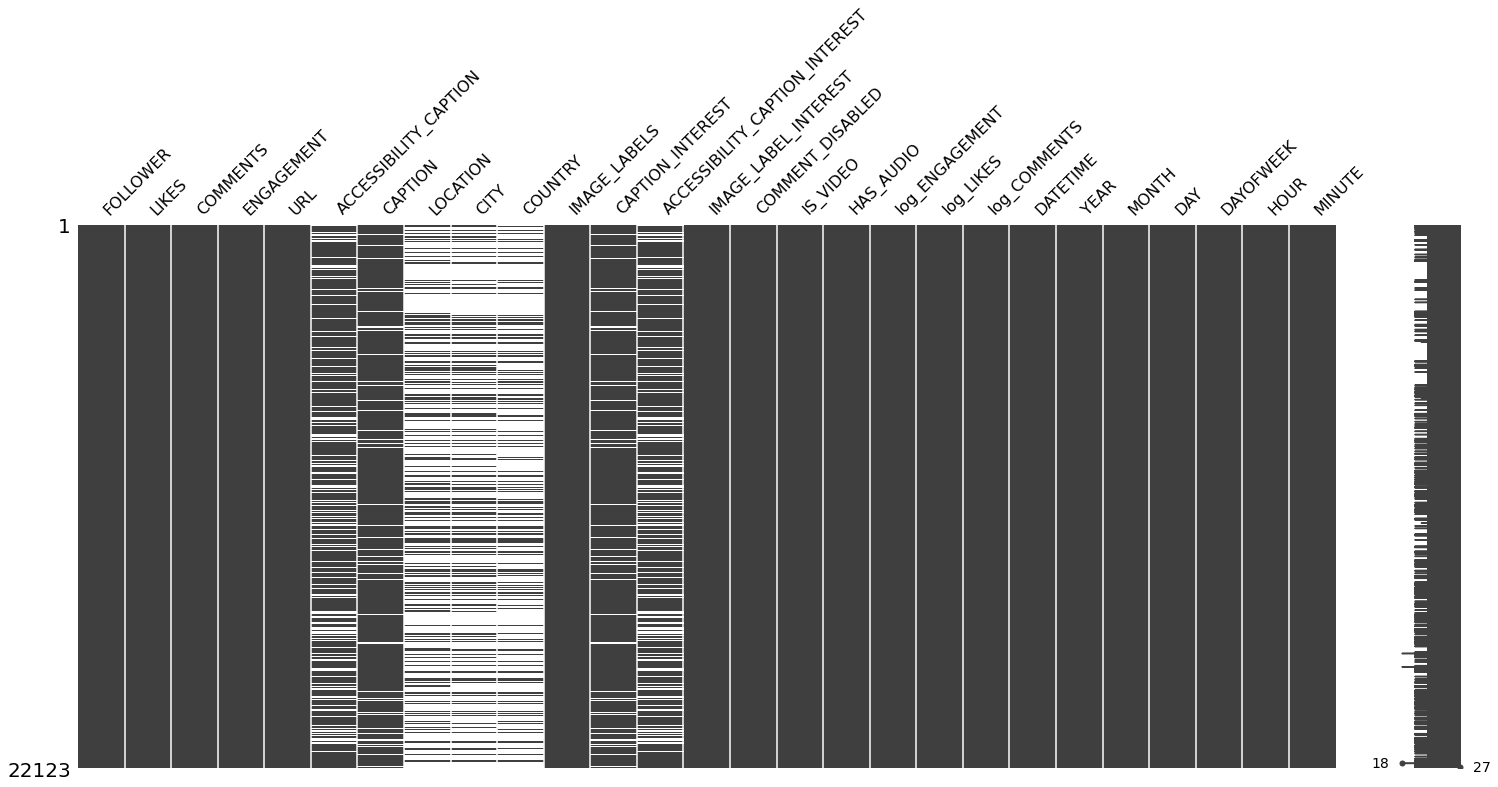

In [295]:
msno.matrix(df)

In [296]:
#https://datatofish.com/rows-with-nan-pandas-dataframe/
#len(df[df['FULLNAME'].isna()]) # 126 #849
#df[df['FULLNAME'].isnull()]
#df[df.isna().any(axis=1)] # len = 4020
#df[df.isnull().any(axis=1)]

In [297]:
for col in df.columns:
    if len(df[df[col].isnull()]) > 0:
      df[col] = df[col].fillna('Null')
      print(col)

ACCESSIBILITY_CAPTION
CAPTION
LOCATION
CITY
COUNTRY
IMAGE_LABELS
CAPTION_INTEREST
ACCESSIBILITY_CAPTION_INTEREST
IMAGE_LABEL_INTEREST


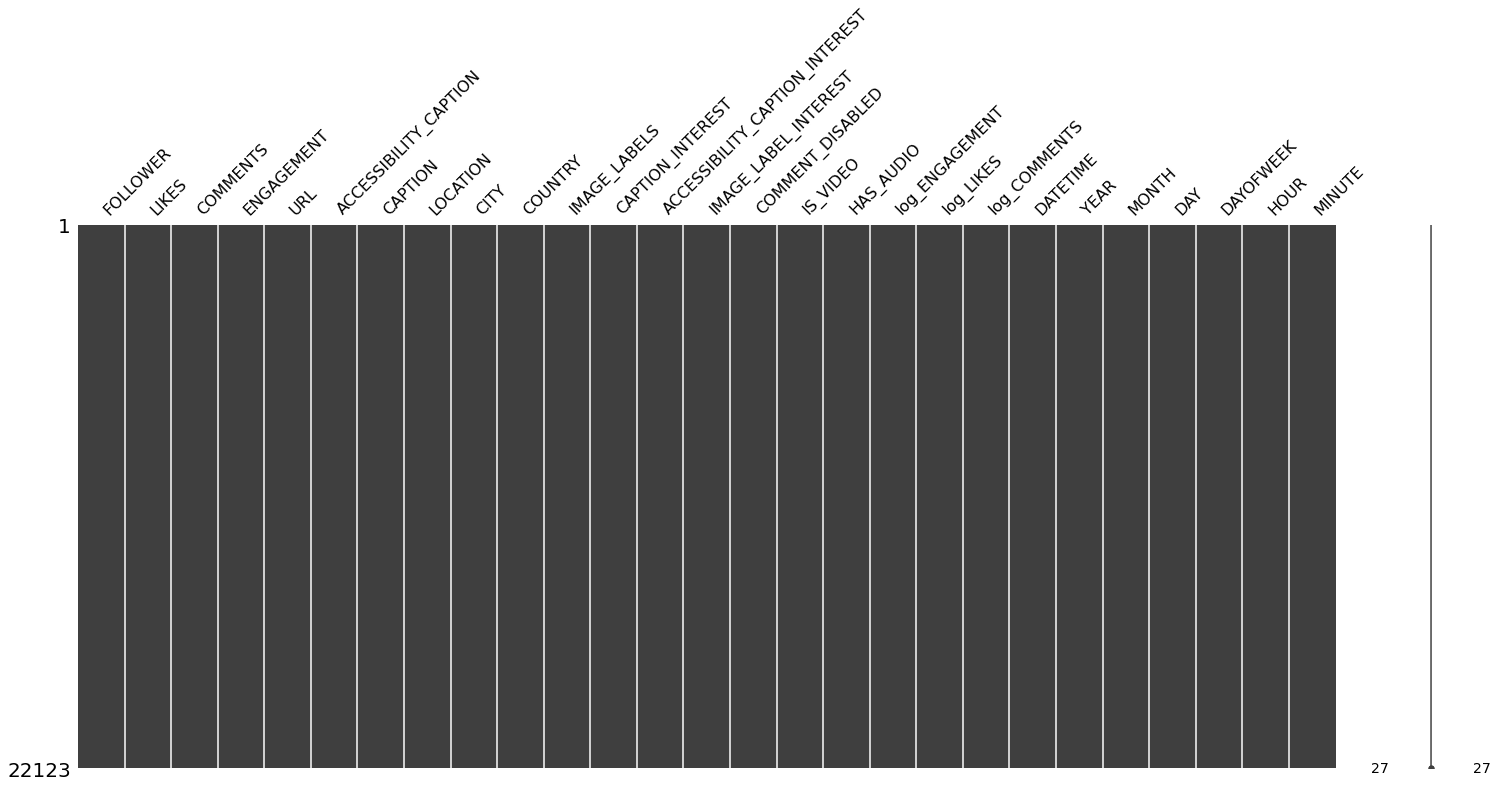

In [298]:
msno.matrix(df)

## creating new columns for featur engeneering base on the columns of CAPTION ,ACCESSIBILITY_CAPTION, IMAGE_LABELS :

new columns for featur engeneering for 'CAPTION','ACCESSIBILITY_CAPTION','IMAGE_LABELS':
*   Number of Hash # in 'CAPTION','ACCESSIBILITY_CAPTION','IMAGE_LABELS',
*   Number of AT @ in CAPTION
*   Number of question mark? in CAPTION
*   Number of , in CAPTION
*   Number of Words in CAPTION

the source for the code is from: https://towardsdatascience.com/9-functions-that-make-natural-language-pre-processing-a-piece-of-cake-8b885c151955 <BR>
7-Oct

In [299]:
#count number of !
#df['exc'] = df['line'].map(lambda x: x.count("!"))

In [300]:
d = pd.DataFrame(df[df.index == 2728].CAPTION)
d

CAPTION
LINE_NUM_INDEX                                                                                                                                                                                                                                                                                                         
2728            Happy 63rd Independence Day Malaysia.!Wish all of Malaysian regardless of races and religion a prosperity and abundance of joy in making our country one of the great. ????????????????????\n.\n.\n.\n#Malaysia #independence #63rd #ohmalaysiaku #onenation #malaysiaprihatin #staysafe #newnormal #rb

In [301]:
'Number_of_expamation_mark_in_CAPTION'.upper()

'NUMBER_OF_EXPAMATION_MARK_IN_CAPTION'

In [302]:
# #Count the most repeated words example:
# pd.DataFrame(Counter('elad elad katz elad katz'.split()).most_common(2000), columns=['word', 'frequency'])

In [303]:
#Count the most repeated words
#from collections import Counter
#pd.DataFrame(Counter(d[['CAPTION']].split()).most_common(200), columns=['word', 'frequency'])

In [304]:
'exclamation'.upper()

'EXCLAMATION'

In [305]:
#Number of Words in CAPTION:
df['NUMBER_OF_WORDS_IN_CAPTION'] = [len(x.split()) for x in df['CAPTION'].tolist()]

In [306]:
df['NUMBER_OF_EXCLAMATION_MARK_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("!"))

In [307]:
df['NUMBER_OF_QUESTION_MARK_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("?"))

In [308]:
df['NUMBER_OF_HASH_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("#"))

In [309]:
df['NUMBER_OF_AT_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("@"))

In [310]:
df['NUMBER_OF_COMMA_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count(","))

New columns for feature engineering cased on Caption:

In [311]:
df['NUMBER_OF_WORDS_IN_CAPTION'] = [len(x.split()) for x in df['CAPTION'].tolist()]
df['NUMBER_OF_EXCLAMATION_MARK_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("!"))
df['NUMBER_OF_QUESTION_MARK_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("?"))
df['NUMBER_OF_HASH_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("#"))
df['NUMBER_OF_AT_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("@"))
df['NUMBER_OF_COMMA_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count(","))

New columns for feature engineering cased on ACCESSIBILITY_CAPTION:

In [312]:
df['NUMBER_OF_WORDS_IN_ACCESSIBILITY_CAPTIONN'] = [len(x.split()) for x in df['ACCESSIBILITY_CAPTION'].tolist()]
df['NUMBER_OF_EXCLAMATION_MARK_IN_ACCESSIBILITY_CAPTION'] = df['ACCESSIBILITY_CAPTION'].map(lambda x: x.count("!"))
df['NUMBER_OF_QUESTION_MARK_IN_ACCESSIBILITY_CAPTION'] = df['ACCESSIBILITY_CAPTION'].map(lambda x: x.count("?"))
df['NUMBER_OF_HASH_IN_ACCESSIBILITY_CAPTION'] = df['ACCESSIBILITY_CAPTION'].map(lambda x: x.count("#"))
df['NUMBER_OF_AT_IN_ACCESSIBILITY_CAPTION'] = df['ACCESSIBILITY_CAPTION'].map(lambda x: x.count("@"))
df['NUMBER_OF_COMMA_IN_ACCESSIBILITY_CAPTION'] = df['ACCESSIBILITY_CAPTION'].map(lambda x: x.count(","))

In [313]:
#10. Count emojis
# import emoji
# emojis_df=[]
# for string in df['line']:
#     my_str = str(string)
#     for each in my_str:
#         if each in emoji.UNICODE_EMOJI:
#             emojis_df.append(each)
# freq = dict(Counter(i for sub in emojis_df for i in set(sub))) 
# sort_orders = sorted(freq.items(), key=lambda x: x[1], reverse=True)

View specific line

In [314]:
d = pd.DataFrame(df[df.index == 2728].CAPTION)

Sampling the row data df:

In [315]:
num_of_samples = 5
list_of_sample_index = list((df.URL.sample(num_of_samples).index.values))
print('indesc sample are: ', list_of_sample_index)
print(df.loc[list_of_sample_index]['URL'])
df.loc[list_of_sample_index][['LIKES','CAPTION','ACCESSIBILITY_CAPTION','IMAGE_LABELS','CAPTION_INTEREST', 'ACCESSIBILITY_CAPTION_INTEREST','IMAGE_LABEL_INTEREST'
,'FOLLOWER','LOCATION'
,'NUMBER_OF_WORDS_IN_CAPTION', 'NUMBER_OF_EXCLAMATION_MARK_IN_CAPTION','NUMBER_OF_QUESTION_MARK_IN_CAPTION','NUMBER_OF_HASH_IN_CAPTION','NUMBER_OF_AT_IN_CAPTION','NUMBER_OF_COMMA_IN_CAPTION' # <- new added columns
]]

indesc sample are:  [28551, 24352, 16995, 27603, 20983]
LINE_NUM_INDEX
28551    https://www.instagram.com/p/CT4iA1oM8WX
24352    https://www.instagram.com/p/CI8Wzl6lWon
16995    https://www.instagram.com/p/CQ5B7yajKy1
27603    https://www.instagram.com/p/COTPBnhJxQb
20983    https://www.instagram.com/p/CTYYjkJoXx8
Name: URL, dtype: object


LIKES  ... NUMBER_OF_COMMA_IN_CAPTION
LINE_NUM_INDEX         ...                           
28551              45  ...                          0
24352               3  ...                          0
16995              33  ...                          0
27603             120  ...                          0
20983             649  ...                          0

[5 rows x 15 columns]

## ## Remove unneccessary columns from Dataframe 2, URL

In [316]:
df.drop(['URL'],inplace=True,axis=1)

In [317]:
df.IMAGE_LABEL_INTEREST.unique()

array(['business', 'style_fashion', 'movies', 'hobbies_interests',
       'travel', 'arts_entertainment', 'food_drink', 'parenting',
       'sports', 'books_literature', 'music', 'home_garden', 'events',
       'weddings', 'legal', 'health', 'education', 'technology_computing',
       'cars_motorcycles', 'accessories', 'news', 'politics', 'gaming',
       'entertainment', 'pets', 'fitness', 'dating_and_relationships',
       'podcasts', 'baking_cooking', 'Null', 'green_living', 'finance',
       'chef', 'desserts_baking', 'comic_books', 'humor'], dtype=object)

In [318]:
df.IMAGE_LABEL_INTEREST.value_counts()

style_fashion               8970
arts_entertainment          2654
travel                      2631
food_drink                  1661
business                    1337
sports                       596
home_garden                  560
technology_computing         436
music                        429
events                       360
pets                         339
entertainment                318
movies                       306
parenting                    297
fitness                      176
books_literature             169
weddings                     135
health                       112
news                          91
education                     79
hobbies_interests             76
politics                      66
legal                         62
dating_and_relationships      54
gaming                        44
podcasts                      43
cars_motorcycles              33
baking_cooking                32
Null                          14
comic_books                   11
accessorie

In [319]:
IMAGE_LABEL_INTEREST = df.groupby(['IMAGE_LABEL_INTEREST']).head(10)
print(IMAGE_LABEL_INTEREST)

                FOLLOWER  ...  NUMBER_OF_COMMA_IN_ACCESSIBILITY_CAPTION
LINE_NUM_INDEX            ...                                          
1918                1052  ...                                         1
1920                 649  ...                                         1
1922                1103  ...                                         0
1929                1076  ...                                         2
1930                1319  ...                                         0
...                  ...  ...                                       ...
28557                718  ...                                         1
32807                617  ...                                         1
28867                718  ...                                         1
30671               5258  ...                                         1
29158             193600  ...                                         1

[332 rows x 38 columns]


## Create bins (buckets) of Likes, Comment Engagement so we can use a classification model

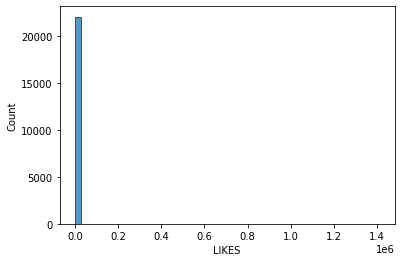

In [320]:
sns.histplot(x = df.LIKES,bins=50)

In [321]:
bins_LIKES=[min(df.LIKES)-1,15,40,200,400,max(df.LIKES)+1]
pd.cut(x=df.LIKES, bins=5).value_counts()
pd.cut(x=df.LIKES, bins=bins_LIKES, labels=bin_labels,
       ordered=True).value_counts()

High         9720
Medium       5043
Low          3628
Extreme      1964
Very High    1768
Name: LIKES, dtype: int64

In [322]:
df['LIKES_RANK'] = pd.cut(x=df.LIKES, bins=bins_LIKES, labels=bin_labels,
       ordered=True)

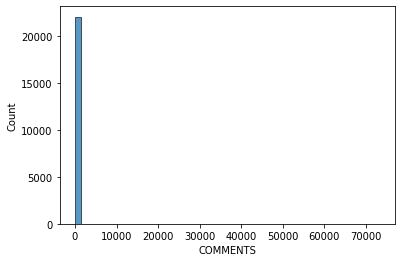

In [323]:
sns.histplot(x = df.COMMENTS,bins=50)

In [324]:
len(df.COMMENTS) #3921

22123

In [325]:
bins_COMMENTS=[min(df.COMMENTS)-1,1,5,40,60,max(df.COMMENTS)]
#pd.cut(x=df.COMMENTS, bins=5).value_counts()
pd.cut(x=df.COMMENTS, bins=bins_COMMENTS#, labels=labels 
        ,ordered=True).value_counts()

(-1, 1]        8394
(5, 40]        6627
(1, 5]         5700
(60, 73188]     818
(40, 60]        584
Name: COMMENTS, dtype: int64

In [326]:
df['COMMENTS_RANK'] = pd.cut(x=df.COMMENTS, bins=bins_COMMENTS, labels=bin_labels 
        ,ordered=True)

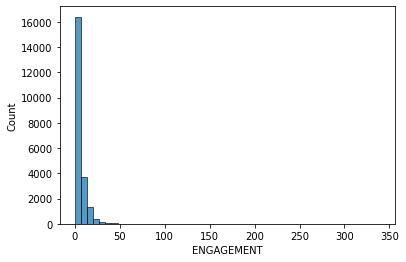

In [327]:
sns.histplot(x = df.ENGAGEMENT,bins=50)

In [328]:
bins_ENGAGEMENT=[min(df.ENGAGEMENT)-1,1.5,3.5,10,15,max(df.ENGAGEMENT)]
pd.cut(x=df.ENGAGEMENT, bins=5, labels=bin_labels, ordered=True).value_counts()
pd.cut(x=df.ENGAGEMENT, bins=bins_ENGAGEMENT, labels=bin_labels, ordered=True).value_counts()

High         6857
Low          6365
Medium       5495
Very High    1767
Extreme      1639
Name: ENGAGEMENT, dtype: int64

In [329]:
df['ENGAGEMENT_RANK'] = pd.cut(x=df.ENGAGEMENT, bins=bins_ENGAGEMENT, labels=bin_labels, ordered=True)

In [330]:
df['ENGAGEMENT_RANK']

LINE_NUM_INDEX
1918      Medium
1920     Extreme
1922        High
1929        High
1930        High
          ...   
35893        Low
35916        Low
36397        Low
36489        Low
37546        Low
Name: ENGAGEMENT_RANK, Length: 22123, dtype: category
Categories (5, object): ['Low' < 'Medium' < 'High' < 'Very High' < 'Extreme']

Convert Rank to Code using Dictionary 

In [331]:
df.columns

Index(['FOLLOWER', 'LIKES', 'COMMENTS', 'ENGAGEMENT', 'ACCESSIBILITY_CAPTION',
       'CAPTION', 'LOCATION', 'CITY', 'COUNTRY', 'IMAGE_LABELS',
       'CAPTION_INTEREST', 'ACCESSIBILITY_CAPTION_INTEREST',
       'IMAGE_LABEL_INTEREST', 'COMMENT_DISABLED', 'IS_VIDEO', 'HAS_AUDIO',
       'log_ENGAGEMENT', 'log_LIKES', 'log_COMMENTS', 'DATETIME', 'YEAR',
       'MONTH', 'DAY', 'DAYOFWEEK', 'HOUR', 'MINUTE',
       'NUMBER_OF_WORDS_IN_CAPTION', 'NUMBER_OF_EXCLAMATION_MARK_IN_CAPTION',
       'NUMBER_OF_QUESTION_MARK_IN_CAPTION', 'NUMBER_OF_HASH_IN_CAPTION',
       'NUMBER_OF_AT_IN_CAPTION', 'NUMBER_OF_COMMA_IN_CAPTION',
       'NUMBER_OF_WORDS_IN_ACCESSIBILITY_CAPTIONN',
       'NUMBER_OF_EXCLAMATION_MARK_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_QUESTION_MARK_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_HASH_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_AT_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_COMMA_IN_ACCESSIBILITY_CAPTION', 'LIKES_RANK',
       'COMMENTS_RANK', 'ENGAGEMENT_RAN

In [332]:
df.LIKES_RANK.unique()

['Medium', 'High', 'Low', 'Very High', 'Extreme']
Categories (5, object): ['Low' < 'Medium' < 'High' < 'Very High' < 'Extreme']

In [333]:
df['COMMENTS_RANK']

LINE_NUM_INDEX
1918        Low
1920     Medium
1922     Medium
1929     Medium
1930       High
          ...  
35893       Low
35916       Low
36397       Low
36489       Low
37546       Low
Name: COMMENTS_RANK, Length: 22123, dtype: category
Categories (5, object): ['Low' < 'Medium' < 'High' < 'Very High' < 'Extreme']

In [334]:
map_dict_rank = {'Low':0.0 , 'Medium':1.0, 'High':2.0, 'Very High':3.0, 'Extreme':4.0}
map_dict_rank

{'Extreme': 4.0, 'High': 2.0, 'Low': 0.0, 'Medium': 1.0, 'Very High': 3.0}

In [335]:
df['LIKES_RANK_INT'] =  df['LIKES_RANK'].map(map_dict_rank).astype(int)

In [336]:
df['COMMENTS_RANK_INT'] =   df['COMMENTS_RANK'].map(map_dict_rank).astype(int)

In [337]:
df['ENGAGEMENT_RANK_INT'] =   df['ENGAGEMENT_RANK'].map(map_dict_rank).astype(int)

In [338]:
df[['LIKES_RANK','LIKES_RANK_INT']].value_counts().sort_index()

LIKES_RANK  LIKES_RANK_INT
Low         0                 3628
Medium      1                 5043
High        2                 9720
Very High   3                 1768
Extreme     4                 1964
dtype: int64

In [339]:
df[['COMMENTS_RANK','COMMENTS_RANK_INT']].value_counts().sort_index()

COMMENTS_RANK  COMMENTS_RANK_INT
Low            0                    8394
Medium         1                    5700
High           2                    6627
Very High      3                     584
Extreme        4                     818
dtype: int64

In [340]:
df[['ENGAGEMENT_RANK','ENGAGEMENT_RANK_INT']].value_counts().sort_index()

ENGAGEMENT_RANK  ENGAGEMENT_RANK_INT
Low              0                      6365
Medium           1                      5495
High             2                      6857
Very High        3                      1767
Extreme          4                      1639
dtype: int64

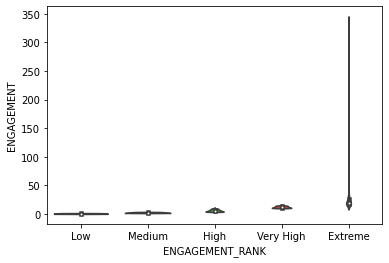

In [341]:
p = sns.violinplot(x='ENGAGEMENT_RANK', y='ENGAGEMENT', 
                    #order=cut_order, 
                    data=df)

## Eladk 28-Sep-2021, more bucketing



1.  VIDEO_VIEW_COUNT          41.148879
2.  FOLLOWER                  35.852012
3.  USERNAME_OBJECT_AS_INT    17.961764
4.  CAPTION_OBJECT_AS_INT      3.558228
5.  HOUR                       1.201713
6.  MINUTE                     0.277403



In [342]:
df.FOLLOWER.value_counts().sort_values(ascending=False).plot.bar()
#.reindex()

Error in callback <function flush_figures at 0x7fbc3d6a7320> (for post_execute):


KeyboardInterrupt: ignored

## Remove OrdinalEncoder, Eladk 8-Oct

*   CAPTION
*   ACCESSIBILITY_CAPTION
*   IMAGE_LABELS 
*   LOCATION
*   CITY  
*   COUNTRY
*   CAPTION_INTEREST 
*   ACCESSIBILITY_CAPTION_INTEREST
*   IMAGE_LABEL_INTEREST

In [343]:
df.IMAGE_LABELS

LINE_NUM_INDEX
1918                                                                                                                             Clothing, Apparel, Text, Money, Collage, Advertisement, Poster
1920                                                                             Clothing, Apparel, Person, Human, Female, Swimwear, Footwear, Woman, Bikini, Shoe, Skin, Pants, Flooring, Girl
1922                              Clothing, Apparel, Person, Human, Sunglasses, Accessories, Accessory, Face, Scarf, Portrait, Photography, Photo, Glasses, People, Selfie, Female, Coat, Smile
1929                                      Person, Human, Clothing, Apparel, Sitting, Shorts, Architecture, Building, Female, Couch, Furniture, Shoe, Footwear, Pillar, Column, Flagstone, Woman
1930                                                                                                                                             Chime, Windchime, Musical Instrument, Lighting
                         

In [347]:
df.select_dtypes(include=['object']).dtypes

ACCESSIBILITY_CAPTION             object
CAPTION                           object
LOCATION                          object
CITY                              object
COUNTRY                           object
IMAGE_LABELS                      object
CAPTION_INTEREST                  object
ACCESSIBILITY_CAPTION_INTEREST    object
IMAGE_LABEL_INTEREST              object
dtype: object

In [ ]:
# beark IMAGE_LABELS to IMAGE_LABELS_WORD

# imdb.genres.str.split('|')
# imdb.genres.str.split('|', expand=True) # create columns for eath genres
# imdb.genres.str.split('|', expand=True).stack() #.value_counts()
# imdb.genres.str.split('|', expand=True).stack().value_counts() #  value to count is genres
# imdb.genres.str.split('|', expand=True).stack().value_counts().plot.bar(figsize=(12,8)) 

In [349]:
df.IMAGE_LABELS.str.split(',')
# df.IMAGE_LABELS.str.split('|', expand=True) # create columns for eath genres
# df.IMAGE_LABELS.str.split('|', expand=True).stack() #.value_counts()
# df.IMAGE_LABELS.str.split('|', expand=True).stack().value_counts() #  value to count is genres
# df.IMAGE_LABELS.str.split('|', expand=True).stack().value_counts().plot.bar(figsize=(12,8)) 

LINE_NUM_INDEX
1918                                                                                                                                           [Clothing,  Apparel,  Text,  Money,  Collage,  Advertisement,  Poster]
1920                                                                                    [Clothing,  Apparel,  Person,  Human,  Female,  Swimwear,  Footwear,  Woman,  Bikini,  Shoe,  Skin,  Pants,  Flooring,  Girl]
1922                                 [Clothing,  Apparel,  Person,  Human,  Sunglasses,  Accessories,  Accessory,  Face,  Scarf,  Portrait,  Photography,  Photo,  Glasses,  People,  Selfie,  Female,  Coat,  Smile]
1929                                          [Person,  Human,  Clothing,  Apparel,  Sitting,  Shorts,  Architecture,  Building,  Female,  Couch,  Furniture,  Shoe,  Footwear,  Pillar,  Column,  Flagstone,  Woman]
1930                                                                                                                             

In [351]:
num_of_samples = 5
list_of_sample_index = list((df.CAPTION.sample(num_of_samples).index.values))
print('indesc sample are: ', list_of_sample_index)
print(df.loc[list_of_sample_index]['CAPTION'])
df.loc[list_of_sample_index][['LIKES','CAPTION','ACCESSIBILITY_CAPTION','IMAGE_LABELS'#,'CAPTION_INTEREST', 'ACCESSIBILITY_CAPTION_INTEREST','IMAGE_LABEL_INTEREST'
,'FOLLOWER','LOCATION'
#,'NUMBER_OF_WORDS_IN_CAPTION', 'NUMBER_OF_EXCLAMATION_MARK_IN_CAPTION','NUMBER_OF_QUESTION_MARK_IN_CAPTION','NUMBER_OF_HASH_IN_CAPTION','NUMBER_OF_AT_IN_CAPTION','NUMBER_OF_COMMA_IN_CAPTION' # <- new added columns
]]

indesc sample are:  [4435, 23256, 26027, 28694, 27098]
LINE_NUM_INDEX
4435                                                                                                                                                                                                                                                                                                 SALE. SALE. SALE!!\n\nYou deserve it, Rambo deserves it. Our ‘I ❤️ Rescue Dogs’ tee is now only $22.\n\n#sale #buyateesaveadog #limitedtime #iloverescuedogs #rescuedog #rescuedogsofinstagram #myfavoritebreedisrescued #rescue #dogmom
23256    @debsreadfeed ???? Shared! \n\n???? @debsreadfeed \n*see her page for full content ! \n\nLast- The Seven Husbands Of Evelyn Hugo @tjenkinsreid \nThe Husbands @chandlerbakerbooks \nThe Five Love Languages @gary_chapman \nWhite Fragility #robindiangelo\n\nNow- Beartown @backmansk \nEducated #tarawestover \n\nNext- Firefly Lane @kristinhannahauthor \nRock Paper Scissors @alicewriterland \n\n#las

LIKES  ...        LOCATION
LINE_NUM_INDEX         ...                
4435               70  ...            Null
23256             149  ...            Null
26027              42  ...  sÃ¸nder strand
28694              66  ...            Null
27098             105  ...            Null

[5 rows x 6 columns]

## Replacing Charecters  with Number uning OrdinalEncoder

In [ ]:
# list of char / object columns

In [ ]:
df.dtypes

FOLLOWER                                                        int64
LIKES                                                           int64
COMMENTS                                                        int64
ENGAGEMENT                                                    float64
ACCESSIBILITY_CAPTION                                          object
CAPTION                                                        object
LOCATION                                                       object
CITY                                                           object
COUNTRY                                                        object
IMAGE_LABELS                                                   object
CAPTION_INTEREST                                               object
ACCESSIBILITY_CAPTION_INTEREST                                 object
IMAGE_LABEL_INTEREST                                           object
COMMENT_DISABLED                                                int64
IS_VIDEO            

In [ ]:
df.select_dtypes(include=['object']).dtypes

ACCESSIBILITY_CAPTION             object
CAPTION                           object
LOCATION                          object
CITY                              object
COUNTRY                           object
IMAGE_LABELS                      object
CAPTION_INTEREST                  object
ACCESSIBILITY_CAPTION_INTEREST    object
IMAGE_LABEL_INTEREST              object
dtype: object

In [ ]:
df.select_dtypes(include=['object']).dtypes.index

Index(['ACCESSIBILITY_CAPTION', 'CAPTION', 'LOCATION', 'CITY', 'COUNTRY',
       'IMAGE_LABELS', 'CAPTION_INTEREST', 'ACCESSIBILITY_CAPTION_INTEREST',
       'IMAGE_LABEL_INTEREST'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22123 entries, 1918 to 37546
Data columns (total 44 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   FOLLOWER                                             22123 non-null  int64         
 1   LIKES                                                22123 non-null  int64         
 2   COMMENTS                                             22123 non-null  int64         
 3   ENGAGEMENT                                           22123 non-null  float64       
 4   ACCESSIBILITY_CAPTION                                22123 non-null  object        
 5   CAPTION                                              22123 non-null  object        
 6   LOCATION                                             22123 non-null  object        
 7   CITY                                                 22123 non-null  object       

In [ ]:
enc = OrdinalEncoder()

Many columns:

In [ ]:
for col in df.select_dtypes(include=['object']).dtypes.index:
#for col in ['USERNAME','FULLNAME']:
  #col_list = pd.DataFrame(df[col].unique())
  #col_list.rename(columns = {0:col},inplace=True)
  #col_list.rename(columns = {0:col},inplace=True)
  enc.fit(df[[col]])
  df[col + '_OBJECT_AS_INT'] = enc.transform(df[[col]])
  #print(col)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22123 entries, 1918 to 37546
Data columns (total 53 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   FOLLOWER                                             22123 non-null  int64         
 1   LIKES                                                22123 non-null  int64         
 2   COMMENTS                                             22123 non-null  int64         
 3   ENGAGEMENT                                           22123 non-null  float64       
 4   ACCESSIBILITY_CAPTION                                22123 non-null  object        
 5   CAPTION                                              22123 non-null  object        
 6   LOCATION                                             22123 non-null  object        
 7   CITY                                                 22123 non-null  object       

In [ ]:
df.head(2)

FOLLOWER  ...  IMAGE_LABEL_INTEREST_OBJECT_AS_INT
LINE_NUM_INDEX            ...                                    
1918                1052  ...                                 5.0
1920                 649  ...                                32.0

[2 rows x 53 columns]

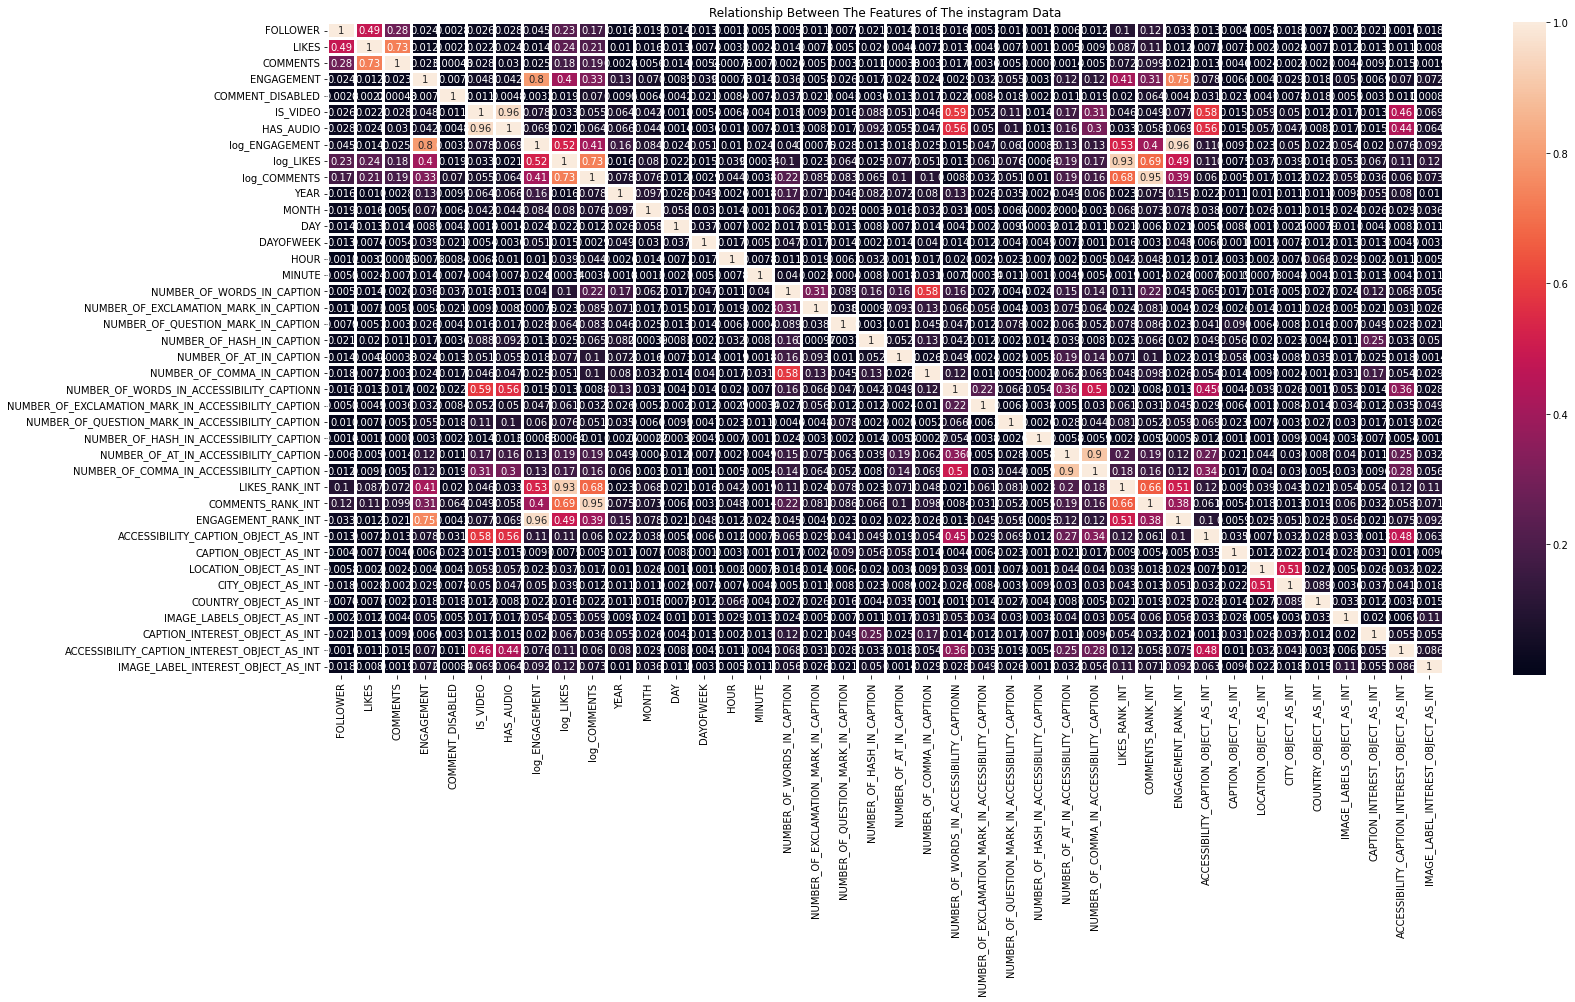

In [ ]:
plt.figure(figsize=(25,12))
plt.title("Relationship Between The Features of The instagram Data")
sns.heatmap(df.corr().abs(), annot=True, linewidths = 2, linecolor = "white")

In [ ]:
# %%time 
# df = df.select_dtypes(include=np.number)
# sns.pairplot(df ,height=1.8) # takes about 5 min.

## More EDA

In [ ]:
df.head(2)

FOLLOWER  ...  IMAGE_LABEL_INTEREST_OBJECT_AS_INT
LINE_NUM_INDEX            ...                                    
1918                1052  ...                                 5.0
1920                 649  ...                                32.0

[2 rows x 53 columns]

## Feature Engneering

## Image captioning

Eladk 2021-Sep-17, we need to:


*   convert y colum to 5 classes so we can have a classification problem and not a regresion model
*   check if the data is inbalance (so we need to use stratify)



# Split the Data for image or video post

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22123 entries, 1918 to 37546
Data columns (total 53 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   FOLLOWER                                             22123 non-null  int64         
 1   LIKES                                                22123 non-null  int64         
 2   COMMENTS                                             22123 non-null  int64         
 3   ENGAGEMENT                                           22123 non-null  float64       
 4   ACCESSIBILITY_CAPTION                                22123 non-null  object        
 5   CAPTION                                              22123 non-null  object        
 6   LOCATION                                             22123 non-null  object        
 7   CITY                                                 22123 non-null  object       

In [ ]:
df_image = df[df['IS_VIDEO'] == 'no']
df_image.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 53 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   FOLLOWER                                             0 non-null      int64         
 1   LIKES                                                0 non-null      int64         
 2   COMMENTS                                             0 non-null      int64         
 3   ENGAGEMENT                                           0 non-null      float64       
 4   ACCESSIBILITY_CAPTION                                0 non-null      object        
 5   CAPTION                                              0 non-null      object        
 6   LOCATION                                             0 non-null      object        
 7   CITY                                                 0 non-null      object        
 8   COUNTRY     

In [ ]:
df_video = df[df['IS_VIDEO']=='yes']
df_video.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 53 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   FOLLOWER                                             0 non-null      int64         
 1   LIKES                                                0 non-null      int64         
 2   COMMENTS                                             0 non-null      int64         
 3   ENGAGEMENT                                           0 non-null      float64       
 4   ACCESSIBILITY_CAPTION                                0 non-null      object        
 5   CAPTION                                              0 non-null      object        
 6   LOCATION                                             0 non-null      object        
 7   CITY                                                 0 non-null      object        
 8   COUNTRY     

# Split the Data for modules

select only int and float column types to X 
seletc LIKES, COMMENTS, ENGAGEMENT as y

In [ ]:
df_image.columns

Index(['FOLLOWER', 'LIKES', 'COMMENTS', 'ENGAGEMENT', 'ACCESSIBILITY_CAPTION',
       'CAPTION', 'LOCATION', 'CITY', 'COUNTRY', 'IMAGE_LABELS',
       'CAPTION_INTEREST', 'ACCESSIBILITY_CAPTION_INTEREST',
       'IMAGE_LABEL_INTEREST', 'COMMENT_DISABLED', 'IS_VIDEO', 'HAS_AUDIO',
       'log_ENGAGEMENT', 'log_LIKES', 'log_COMMENTS', 'DATETIME', 'YEAR',
       'MONTH', 'DAY', 'DAYOFWEEK', 'HOUR', 'MINUTE',
       'NUMBER_OF_WORDS_IN_CAPTION', 'NUMBER_OF_EXCLAMATION_MARK_IN_CAPTION',
       'NUMBER_OF_QUESTION_MARK_IN_CAPTION', 'NUMBER_OF_HASH_IN_CAPTION',
       'NUMBER_OF_AT_IN_CAPTION', 'NUMBER_OF_COMMA_IN_CAPTION',
       'NUMBER_OF_WORDS_IN_ACCESSIBILITY_CAPTIONN',
       'NUMBER_OF_EXCLAMATION_MARK_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_QUESTION_MARK_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_HASH_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_AT_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_COMMA_IN_ACCESSIBILITY_CAPTION', 'LIKES_RANK',
       'COMMENTS_RANK', 'ENGAGEMENT_RAN

In [ ]:
df_video.columns

Index(['FOLLOWER', 'LIKES', 'COMMENTS', 'ENGAGEMENT', 'ACCESSIBILITY_CAPTION',
       'CAPTION', 'LOCATION', 'CITY', 'COUNTRY', 'IMAGE_LABELS',
       'CAPTION_INTEREST', 'ACCESSIBILITY_CAPTION_INTEREST',
       'IMAGE_LABEL_INTEREST', 'COMMENT_DISABLED', 'IS_VIDEO', 'HAS_AUDIO',
       'log_ENGAGEMENT', 'log_LIKES', 'log_COMMENTS', 'DATETIME', 'YEAR',
       'MONTH', 'DAY', 'DAYOFWEEK', 'HOUR', 'MINUTE',
       'NUMBER_OF_WORDS_IN_CAPTION', 'NUMBER_OF_EXCLAMATION_MARK_IN_CAPTION',
       'NUMBER_OF_QUESTION_MARK_IN_CAPTION', 'NUMBER_OF_HASH_IN_CAPTION',
       'NUMBER_OF_AT_IN_CAPTION', 'NUMBER_OF_COMMA_IN_CAPTION',
       'NUMBER_OF_WORDS_IN_ACCESSIBILITY_CAPTIONN',
       'NUMBER_OF_EXCLAMATION_MARK_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_QUESTION_MARK_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_HASH_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_AT_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_COMMA_IN_ACCESSIBILITY_CAPTION', 'LIKES_RANK',
       'COMMENTS_RANK', 'ENGAGEMENT_RAN

In [ ]:
X = df.select_dtypes(include=['number'])
X.drop(['LIKES','COMMENTS','ENGAGEMENT','log_ENGAGEMENT'], axis=1, inplace=True) #['LIKES','COMMENTS','ENGAGEMENT']

In [ ]:
X.drop(['LIKES_RANK_INT','COMMENTS_RANK_INT','ENGAGEMENT_RANK_INT'], axis=1, inplace=True) #['LIKES','COMMENTS','ENGAGEMENT']

In [ ]:
X.drop(['log_LIKES','log_COMMENTS'], axis=1, inplace=True) #['LIKES','COMMENTS','ENGAGEMENT']

In [ ]:
df_video.columns

Index(['FOLLOWER', 'LIKES', 'COMMENTS', 'ENGAGEMENT', 'ACCESSIBILITY_CAPTION',
       'CAPTION', 'LOCATION', 'CITY', 'COUNTRY', 'IMAGE_LABELS',
       'CAPTION_INTEREST', 'ACCESSIBILITY_CAPTION_INTEREST',
       'IMAGE_LABEL_INTEREST', 'COMMENT_DISABLED', 'IS_VIDEO', 'HAS_AUDIO',
       'log_ENGAGEMENT', 'log_LIKES', 'log_COMMENTS', 'DATETIME', 'YEAR',
       'MONTH', 'DAY', 'DAYOFWEEK', 'HOUR', 'MINUTE',
       'NUMBER_OF_WORDS_IN_CAPTION', 'NUMBER_OF_EXCLAMATION_MARK_IN_CAPTION',
       'NUMBER_OF_QUESTION_MARK_IN_CAPTION', 'NUMBER_OF_HASH_IN_CAPTION',
       'NUMBER_OF_AT_IN_CAPTION', 'NUMBER_OF_COMMA_IN_CAPTION',
       'NUMBER_OF_WORDS_IN_ACCESSIBILITY_CAPTIONN',
       'NUMBER_OF_EXCLAMATION_MARK_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_QUESTION_MARK_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_HASH_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_AT_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_COMMA_IN_ACCESSIBILITY_CAPTION', 'LIKES_RANK',
       'COMMENTS_RANK', 'ENGAGEMENT_RAN

In [ ]:
y = df['ENGAGEMENT']
y1 = df['LIKES']
y2 = df['COMMENTS']
y3 = df['log_ENGAGEMENT']
y_ENGAGEMENT_RANK_INT = df['ENGAGEMENT_RANK_INT']
y_LIKES_RANK_INT = df['LIKES_RANK_INT']
y_COMMENTS_RANK_INT = df['COMMENTS_RANK_INT']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y3, train_size = train_size\
                           , random_state = rand_state)#, stratify = df.ENGAGEMENT)

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Labels (y) Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels(y) Shape:', y_test.shape)

Training Features Shape: (16592, 31)
Training Labels (y) Shape: (16592,)
Testing Features Shape: (5531, 31)
Testing Labels(y) Shape: (5531,)


# Mechine Learning  Model for df_image

## Appling First1 Model - KNN model

In [ ]:
rmse_val = [] #to store rmse values for different k
for K in range(30):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = (mse(y_test,pred))**0.5 #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.9601755783140533
RMSE value for k=  2 is: 0.8508115668818942
RMSE value for k=  3 is: 0.8135857877784438
RMSE value for k=  4 is: 0.7904502567972221
RMSE value for k=  5 is: 0.7810993315935226
RMSE value for k=  6 is: 0.7760034257785668
RMSE value for k=  7 is: 0.7717887217207365
RMSE value for k=  8 is: 0.7713287541982286
RMSE value for k=  9 is: 0.7687832975652638
RMSE value for k=  10 is: 0.7691617014083191
RMSE value for k=  11 is: 0.7682809300518678
RMSE value for k=  12 is: 0.7689434495130205
RMSE value for k=  13 is: 0.7687992794155485
RMSE value for k=  14 is: 0.7688052818785461
RMSE value for k=  15 is: 0.7701150794024123
RMSE value for k=  16 is: 0.7705345884723354
RMSE value for k=  17 is: 0.7700600384372568
RMSE value for k=  18 is: 0.7696436236071594
RMSE value for k=  19 is: 0.7689624097115844
RMSE value for k=  20 is: 0.7683106721184652
RMSE value for k=  21 is: 0.7677785617442894
RMSE value for k=  22 is: 0.7680537797299395
RMSE value for k=  

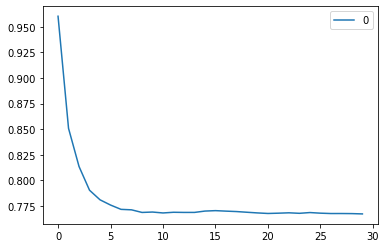

In [ ]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [ ]:
min_mse_k = min(rmse_val)
min_index = rmse_val.index(min_mse_k)
print(min_index, min_mse_k)

29 0.7673406350868764


In [ ]:
neighbor = min_index
knn_model_1 = KNeighborsRegressor(n_neighbors=neighbor).fit(X_train, y_train)

In [ ]:
y_train_pred = knn_model_1.predict(X_train)

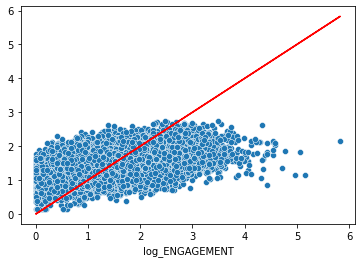

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(y_train[-150:]))), y=y_train[-150:],
                         mode='lines',
                         name='Prediction'))
fig.add_trace(go.Scatter(x=list(range(len(y_train_pred[-150:]))), y=y_train_pred[-150:],
                         mode='lines',
                         name='True value'))

fig.show()

## Validating the Model 

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

0.731537278099342

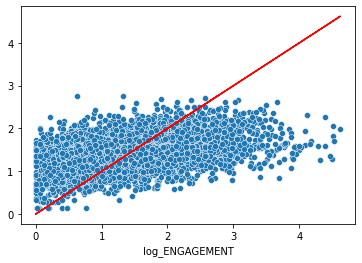

In [ ]:
y_test_pred = knn_model_1.predict(X_test)
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
print('RMSE ', RMSE)

print('r2_score: ', round(r2_score(y_test, y_test_pred)*100, 2))

RMSE  0.7676423160500594
r2_score:  17.99


## Scaled MaxAbsScaler model

In [ ]:
my_scaler = MaxAbsScaler().fit(X_train)
X_train_scaled = pd.DataFrame(my_scaler.transform(X_train), columns=X_train.columns)
X_train_scaled.head()

FOLLOWER  ...  IMAGE_LABEL_INTEREST_OBJECT_AS_INT
0  0.000384  ...                            0.914286
1  0.000028  ...                            0.914286
2  0.000060  ...                            0.914286
3  0.000066  ...                            0.971429
4  0.000255  ...                            0.914286

[5 rows x 31 columns]

In [ ]:
knn_model_2 = KNeighborsRegressor(n_neighbors=10).fit(X_train_scaled, y_train)

In [ ]:
y_train_pred = knn_model_2.predict(X_train_scaled)

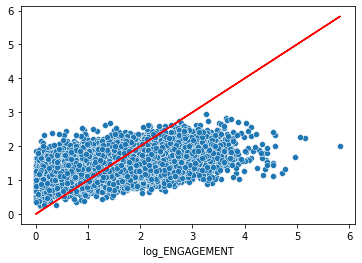

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

0.7418622901226195

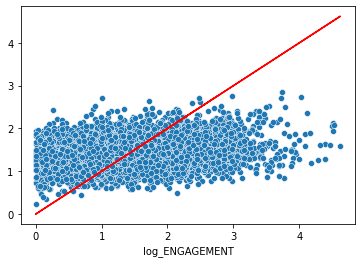

In [ ]:
X_test_scaled = my_scaler.transform(X_test)
y_test_pred = knn_model_2.predict(X_test_scaled)

ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

0.8265626394279918

## Appling 2nd Model - Decision Tree with bins

In [ ]:
# model_2_dt = DecisionTreeClassifier(
#     min_samples_leaf=3
#     ,max_depth=5
#     )

In [ ]:
model_2_dt_pred_like = DecisionTreeClassifier(
    min_samples_leaf=3
    ,max_depth=5
    )

In [ ]:
model_2_dt_pred_comments = DecisionTreeClassifier(
    min_samples_leaf=3
    ,max_depth=5
    )

In [ ]:
X.columns

Index(['FOLLOWER', 'COMMENT_DISABLED', 'IS_VIDEO', 'HAS_AUDIO', 'YEAR',
       'MONTH', 'DAY', 'DAYOFWEEK', 'HOUR', 'MINUTE',
       'NUMBER_OF_WORDS_IN_CAPTION', 'NUMBER_OF_EXCLAMATION_MARK_IN_CAPTION',
       'NUMBER_OF_QUESTION_MARK_IN_CAPTION', 'NUMBER_OF_HASH_IN_CAPTION',
       'NUMBER_OF_AT_IN_CAPTION', 'NUMBER_OF_COMMA_IN_CAPTION',
       'NUMBER_OF_WORDS_IN_ACCESSIBILITY_CAPTIONN',
       'NUMBER_OF_EXCLAMATION_MARK_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_QUESTION_MARK_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_HASH_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_AT_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_COMMA_IN_ACCESSIBILITY_CAPTION',
       'ACCESSIBILITY_CAPTION_OBJECT_AS_INT', 'CAPTION_OBJECT_AS_INT',
       'LOCATION_OBJECT_AS_INT', 'CITY_OBJECT_AS_INT', 'COUNTRY_OBJECT_AS_INT',
       'IMAGE_LABELS_OBJECT_AS_INT', 'CAPTION_INTEREST_OBJECT_AS_INT',
       'ACCESSIBILITY_CAPTION_INTEREST_OBJECT_AS_INT',
       'IMAGE_LABEL_INTEREST_OBJECT_AS_INT'],
      dtype='

In [ ]:
# model_2_dt.fit(X, 
#               y_ENGAGEMENT_RANK_INT)

In [ ]:
model_2_dt_pred_like.fit(X, 
              y_LIKES_RANK_INT)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
model_2_dt_pred_comments.fit(X, 
              y_COMMENTS_RANK_INT)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
class_list = [str(x) for x in model_2_dt_pred_comments.classes_]
class_list

['0', '1', '2', '3', '4']

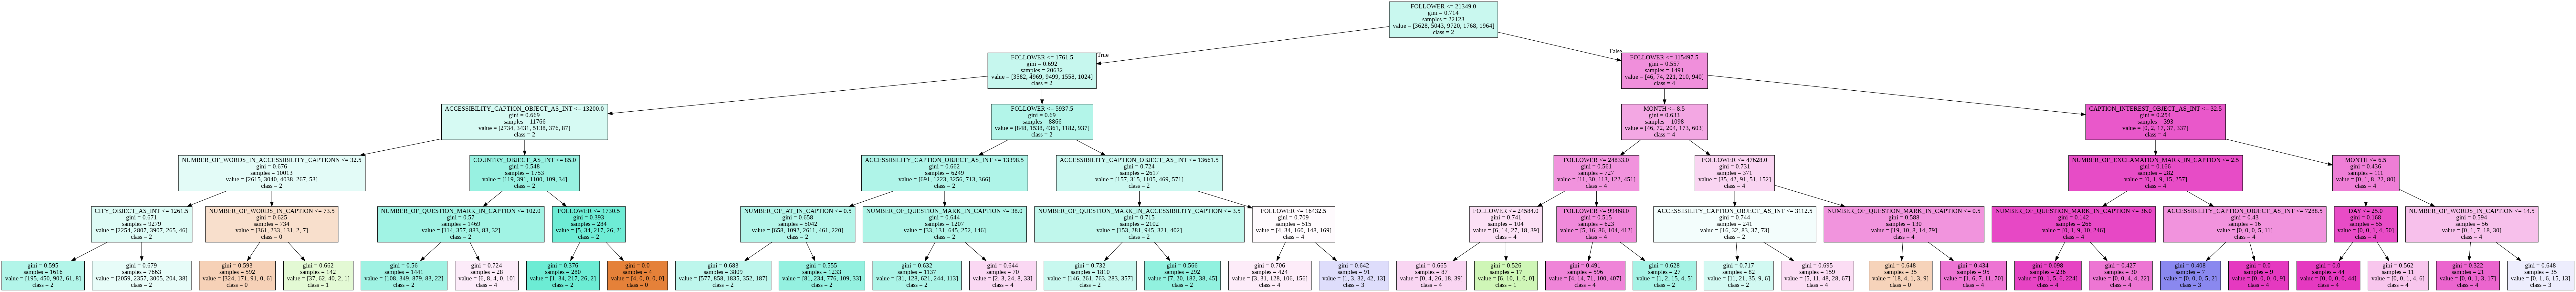

In [ ]:
dot_data = StringIO()  
export_graphviz(model_2_dt_pred_like, out_file=dot_data, feature_names=X.columns, 
                leaves_parallel=True, filled=True, class_names=[str(x) for x in model_2_dt_pred_like.classes_])
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=1000) 

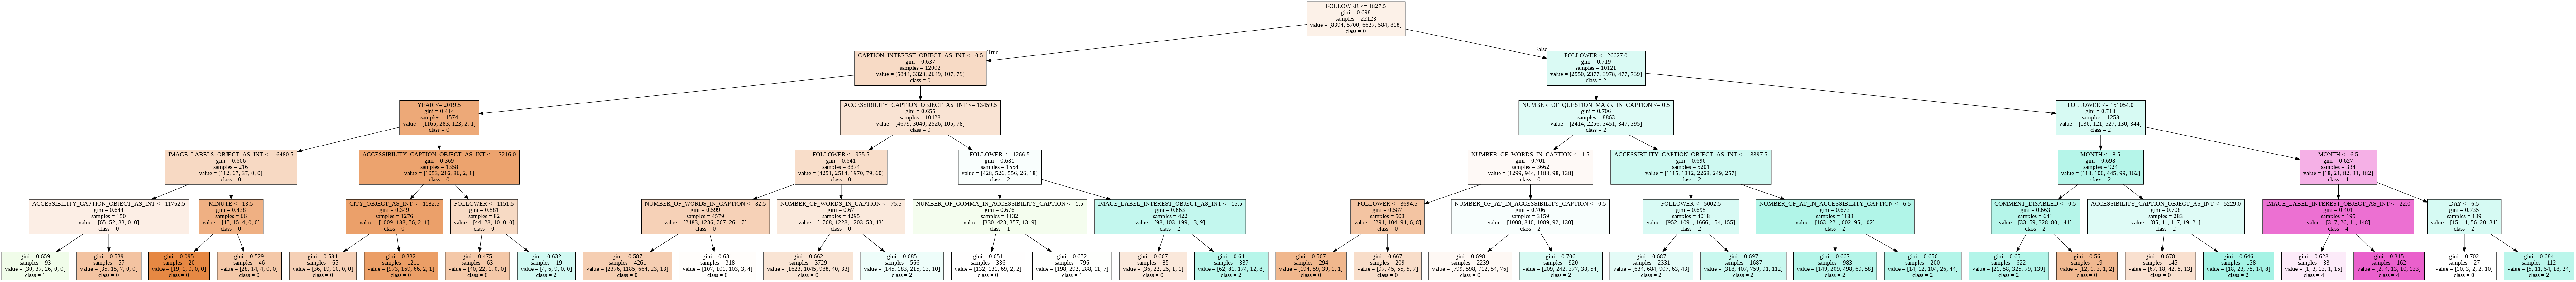

In [ ]:
dot_data = StringIO()  
export_graphviz(model_2_dt_pred_comments, out_file=dot_data, feature_names=X.columns, 
                leaves_parallel=True, filled=True, class_names=[str(x) for x in model_2_dt_pred_comments.classes_])
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=1000) 

View Features Emportance:

In [ ]:
pd.Series(model_2_dt_pred_like.feature_importances_*100,
          index=X.columns).sort_values(ascending=False).round()

FOLLOWER                                               69.0
ACCESSIBILITY_CAPTION_OBJECT_AS_INT                    13.0
NUMBER_OF_WORDS_IN_ACCESSIBILITY_CAPTIONN               5.0
CITY_OBJECT_AS_INT                                      4.0
NUMBER_OF_QUESTION_MARK_IN_CAPTION                      2.0
NUMBER_OF_AT_IN_CAPTION                                 2.0
MONTH                                                   1.0
NUMBER_OF_WORDS_IN_CAPTION                              1.0
NUMBER_OF_QUESTION_MARK_IN_ACCESSIBILITY_CAPTION        1.0
COUNTRY_OBJECT_AS_INT                                   1.0
CAPTION_INTEREST_OBJECT_AS_INT                          0.0
DAY                                                     0.0
NUMBER_OF_EXCLAMATION_MARK_IN_CAPTION                   0.0
HAS_AUDIO                                               0.0
IS_VIDEO                                                0.0
YEAR                                                    0.0
DAYOFWEEK                               

In [ ]:
pd.Series(model_2_dt_pred_comments.feature_importances_*100,
          index=X.columns).sort_values(ascending=False).round()

FOLLOWER                                               56.0
CAPTION_INTEREST_OBJECT_AS_INT                         12.0
ACCESSIBILITY_CAPTION_OBJECT_AS_INT                    10.0
NUMBER_OF_WORDS_IN_CAPTION                              6.0
NUMBER_OF_QUESTION_MARK_IN_CAPTION                      5.0
MONTH                                                   3.0
NUMBER_OF_AT_IN_ACCESSIBILITY_CAPTION                   2.0
YEAR                                                    1.0
IMAGE_LABEL_INTEREST_OBJECT_AS_INT                      1.0
NUMBER_OF_COMMA_IN_ACCESSIBILITY_CAPTION                1.0
COMMENT_DISABLED                                        1.0
DAY                                                     0.0
CITY_OBJECT_AS_INT                                      0.0
IMAGE_LABELS_OBJECT_AS_INT                              0.0
MINUTE                                                  0.0
NUMBER_OF_EXCLAMATION_MARK_IN_ACCESSIBILITY_CAPTION     0.0
DAYOFWEEK                               

Eladk 2021-Sep-24 comment in first model:

*   Why Time is So meaning full?
*   What ACCESSIBILITY_CAPTION have corolation with ranking?
*   I Need to understand why folloer is very meaningfull
*   I Need to understand why USERNAME,userid is very meaningfull

In [ ]:
df.head(3)

FOLLOWER  ...  IMAGE_LABEL_INTEREST_OBJECT_AS_INT
LINE_NUM_INDEX            ...                                    
1918                1052  ...                                 5.0
1920                 649  ...                                32.0
1922                1103  ...                                32.0

[3 rows x 53 columns]

In [ ]:
df['LIKES_RANK_INT_pred'] = model_2_dt_pred_like.predict(X)
df.head(1)

FOLLOWER  ...  LIKES_RANK_INT_pred
LINE_NUM_INDEX            ...                     
1918                1052  ...                    2

[1 rows x 54 columns]

In [ ]:
df['COMMENTS_RANK_INT_pred'] = model_2_dt_pred_comments.predict(X)
df.head(1)

FOLLOWER  LIKES  ...  LIKES_RANK_INT_pred  COMMENTS_RANK_INT_pred
LINE_NUM_INDEX                   ...                                             
1918                1052     23  ...                    2                       0

[1 rows x 55 columns]

In [ ]:
s = pd.Series(model_2_dt_pred_like.feature_importances_*100,
          index=X.columns).sort_values(ascending=False)

s[s.gt(0)]

FOLLOWER                                            69.209193
ACCESSIBILITY_CAPTION_OBJECT_AS_INT                 13.458954
NUMBER_OF_WORDS_IN_ACCESSIBILITY_CAPTIONN            4.956222
CITY_OBJECT_AS_INT                                   4.030401
NUMBER_OF_QUESTION_MARK_IN_CAPTION                   2.222232
NUMBER_OF_AT_IN_CAPTION                              1.724211
MONTH                                                1.306994
NUMBER_OF_WORDS_IN_CAPTION                           1.054748
NUMBER_OF_QUESTION_MARK_IN_ACCESSIBILITY_CAPTION     0.785604
COUNTRY_OBJECT_AS_INT                                0.667011
CAPTION_INTEREST_OBJECT_AS_INT                       0.281360
DAY                                                  0.182860
NUMBER_OF_EXCLAMATION_MARK_IN_CAPTION                0.120209
dtype: float64

In [ ]:
s = pd.Series(model_2_dt_pred_comments.feature_importances_*100,
          index=X.columns).sort_values(ascending=False)

s[s.gt(0)]

FOLLOWER                                    56.124733
CAPTION_INTEREST_OBJECT_AS_INT              12.146913
ACCESSIBILITY_CAPTION_OBJECT_AS_INT          9.721122
NUMBER_OF_WORDS_IN_CAPTION                   6.317054
NUMBER_OF_QUESTION_MARK_IN_CAPTION           5.072948
MONTH                                        3.457233
NUMBER_OF_AT_IN_ACCESSIBILITY_CAPTION        1.924447
YEAR                                         1.336259
IMAGE_LABEL_INTEREST_OBJECT_AS_INT           0.988500
NUMBER_OF_COMMA_IN_ACCESSIBILITY_CAPTION     0.772922
COMMENT_DISABLED                             0.672877
DAY                                          0.472925
CITY_OBJECT_AS_INT                           0.420446
IMAGE_LABELS_OBJECT_AS_INT                   0.383892
MINUTE                                       0.187730
dtype: float64

In [ ]:
# map_dict_ENGAGEMENT = dict(zip(df.ENGAGEMENT_RANK_INT,df.ENGAGEMENT_RANK))
# map_dict_ENGAGEMENT

In [ ]:
#df['ENGAGEMENT_RANK_pred'] = df['ENGAGEMENT_RANK_INT_pred'].map(map_dict_ENGAGEMENT)

Evanuating the Model:

In [ ]:
#type(df[['ENGAGEMENT_RANK','ENGAGEMENT_RANK_pred']].value_counts())

In [ ]:
df[['LIKES_RANK_INT','LIKES_RANK_INT_pred']].value_counts().sort_index()

LIKES_RANK_INT  LIKES_RANK_INT_pred
0               0                       346
                1                        43
                2                      3217
                3                         1
                4                        21
1               0                       175
                1                        72
                2                      4714
                3                         4
                4                        78
2               0                        92
                1                        41
                2                      9230
                3                        38
                4                       319
3               0                         3
                1                         2
                2                      1413
                3                        62
                4                       288
4               0                        15
                1                       

In [ ]:
df[['COMMENTS_RANK_INT','COMMENTS_RANK_INT_pred']].value_counts().sort_index()

COMMENTS_RANK_INT  COMMENTS_RANK_INT_pred
0                  0                         6584
                   1                          228
                   2                         1579
                   4                            3
1                  0                         3448
                   1                          329
                   2                         1916
                   4                            7
2                  0                         2790
                   1                          314
                   2                         3497
                   4                           26
3                  0                          139
                   1                           11
                   2                          423
                   4                           11
4                  0                          163
                   1                            7
                   2                          500
        

In [ ]:
cm = confusion_matrix(y_true=df.LIKES_RANK_INT,
                      y_pred=df.LIKES_RANK_INT_pred)
pd.DataFrame(cm,
             index=model_2_dt_pred_like.classes_,
             columns=model_2_dt_pred_like.classes_)

0   1     2   3     4
0  346  43  3217   1    21
1  175  72  4714   4    78
2   92  41  9230  38   319
3    3   2  1413  62   288
4   15   1   816  28  1104

In [ ]:
cm = confusion_matrix(y_true=df.COMMENTS_RANK_INT,
                      y_pred=df.COMMENTS_RANK_INT_pred)
pd.DataFrame(cm,
             index=model_2_dt_pred_like.classes_,
             columns=model_2_dt_pred_like.classes_)

0    1     2  3    4
0  6584  228  1579  0    3
1  3448  329  1916  0    7
2  2790  314  3497  0   26
3   139   11   423  0   11
4   163    7   500  0  148

In [ ]:
print(classification_report(y_true=df.LIKES_RANK_INT,
                      y_pred=df.LIKES_RANK_INT_pred))

              precision    recall  f1-score   support

           0       0.55      0.10      0.16      3628
           1       0.45      0.01      0.03      5043
           2       0.48      0.95      0.63      9720
           3       0.47      0.04      0.07      1768
           4       0.61      0.56      0.59      1964

    accuracy                           0.49     22123
   macro avg       0.51      0.33      0.29     22123
weighted avg       0.49      0.49      0.37     22123



In [ ]:
print(classification_report(y_true=df.COMMENTS_RANK_INT,
                      y_pred=df.COMMENTS_RANK_INT_pred))

              precision    recall  f1-score   support

           0       0.50      0.78      0.61      8394
           1       0.37      0.06      0.10      5700
           2       0.44      0.53      0.48      6627
           3       0.00      0.00      0.00       584
           4       0.76      0.18      0.29       818

    accuracy                           0.48     22123
   macro avg       0.41      0.31      0.30     22123
weighted avg       0.45      0.48      0.41     22123



In [ ]:
accuracy_score(y_true=df.LIKES_RANK_INT, y_pred=df.LIKES_RANK_INT_pred)

0.4888125480269403

In [ ]:
accuracy_score(y_true=df.COMMENTS_RANK_INT, y_pred=df.COMMENTS_RANK_INT_pred)

0.4772408805315735

In [ ]:
# s = pd.Series(model_2_dt_pred_comments.feature_importances_*100,
#           index=X.columns).sort_values(ascending=False)

# s[s.gt(0)]

In [ ]:
# p = sns.violinplot(x='ENGAGEMENT_RANK', y='HOUR', 
#                     #order=cut_order, 
#                     data=df)

In [ ]:
# for index, val in pd.Series(model_2_dt.feature_importances_*100,index=X.columns).iteritems():
#   if val > 0:
#     plt.figure()
#     p = sns.violinplot(x='ENGAGEMENT_RANK', y=index, 
#                     #order=cut_order, 
#                     data=df)
    

## Scoring 

## Appling 3nd Model - Random Forest regression

In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = rand_state)
# Train the model on training data
rf.fit(X_train, y_train);

In [ ]:
# Use the forest's predict method on the test data
rf_predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(rf_predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'log_of_enegament.')

Mean Absolute Error: 0.46 log_of_enegament.


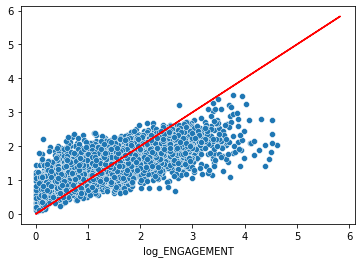

In [ ]:
ax = sns.scatterplot(x=y_test, y=rf_predictions)
ax.plot(y_train, y_train, 'r')

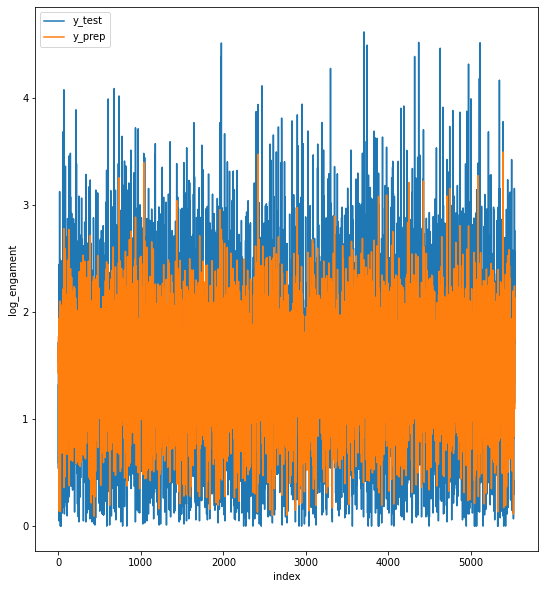

In [ ]:
x = np.linspace(0, len(y_test), len(y_test))
fig = plt.figure(figsize=(9, 10))
plt.plot(x, y_test, label='y_test')
plt.plot(x, rf_predictions, label='y_prep')
plt.xlabel('index')
plt.ylabel('log_engament')
plt.legend()
plt.show()

In [ ]:
rf_y_train_pred = rf.predict(X_train)
RMSE = mse(y_train, rf_y_train_pred)**0.5
RMSE

0.21530357309777562

In [ ]:
rf_y_test_pred = rf.predict(X_test)
RMSE = mse(y_test, rf_y_test_pred)**0.5
RMSE


0.5832512823842146

In [ ]:
pd.Series(rf.feature_importances_, index=X_train.columns).\
sort_values(ascending=False)

FOLLOWER                                               0.220699
ACCESSIBILITY_CAPTION_OBJECT_AS_INT                    0.108082
CAPTION_OBJECT_AS_INT                                  0.053648
IMAGE_LABELS_OBJECT_AS_INT                             0.051326
NUMBER_OF_WORDS_IN_CAPTION                             0.044784
NUMBER_OF_WORDS_IN_ACCESSIBILITY_CAPTIONN              0.044233
DAY                                                    0.042050
MONTH                                                  0.040906
MINUTE                                                 0.037605
HOUR                                                   0.035408
CAPTION_INTEREST_OBJECT_AS_INT                         0.035293
IMAGE_LABEL_INTEREST_OBJECT_AS_INT                     0.031880
NUMBER_OF_HASH_IN_CAPTION                              0.028421
NUMBER_OF_QUESTION_MARK_IN_CAPTION                     0.025133
LOCATION_OBJECT_AS_INT                                 0.022115
YEAR                                    

In [ ]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 990,
 'verbose': 0,
 'warm_start': False}


In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [20, 35, 50],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [215]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_
{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
#Model Performance
#Average Error: 3.6561 degrees.
#Accuracy = 93.83%.
#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))
#Improvement of 0.50%.

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 10.5min


KeyboardInterrupt: ignored

In [ ]:
grid_search.best_params_

## Appling 4nd Model - Random Forest Classification 

In [ ]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, y_LIKES_RANK_INT, train_size = train_size\
                           , random_state = rand_state)#, stratify = df.ENGAGEMENT)

In [ ]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, y_COMMENTS_RANK_INT, train_size = train_size\
                           , random_state = rand_state)#, stratify = df.ENGAGEMENT)

In [ ]:
X_train_4.drop(columns='VIDEO_VIEW_COUNT', inplace=True)
X_test_4.drop(columns='VIDEO_VIEW_COUNT', inplace=True)

In [ ]:
X_train_4.columns

In [ ]:
model_rf_4 = RandomForestClassifier()

model_rf_4.fit(X_train_4,y_train_4) # X_test_4 is Engagment_rank
preds= model_rf_4.predict_proba(X_train_4)[:,1]

#roc_auc_score(y_test_4,preds)

In [ ]:
# map_dict_ENGAGEMENT = dict(zip(df.ENGAGEMENT_RANK_INT,df.ENGAGEMENT_RANK))

In [ ]:
pd.Series(model_rf_4.feature_importances_*100, index=X_train_4.columns).sort_values(ascending=False).round()#.plot.barh(figsize=(14,12))

In [ ]:
from sklearn import tree

In [ ]:
import six

In [ ]:
_ = tree.plot_tree(model_rf_4.estimators_[0], feature_names=X_train_4.columns, filled=True)

In [ ]:
X_train_4.columns

In [ ]:
X_train_4.head(3)

In [ ]:
X_train_4['y_ENGAGEMENT_RANK_INT_pred_rf'] = model_rf_4.predict(X_train_4)

In [ ]:
X_train_4.head(3)

In [ ]:
X_train_4 = pd.concat([X_train_4, y_train_4], axis=1).reset_index()

In [ ]:
X_train_4.head(3)

In [ ]:
print(len(X_train_4))

In [ ]:
len(X_train_4[X_train_4.y_ENGAGEMENT_RANK_INT_pred_rf == X_train_4.ENGAGEMENT_RANK_INT])

In [ ]:
cm = confusion_matrix(y_true=y_train_4,
                      y_pred=X_train_4['y_ENGAGEMENT_RANK_INT_pred_rf'])
pd.DataFrame(cm,
             index=model_rf_4.classes_,
             columns=model_rf_4.classes_)

In [ ]:
X_train_4.columns

In [ ]:
print(classification_report(y_true=y_train_4,
                      y_pred=X_train_4.y_ENGAGEMENT_RANK_INT_pred_rf))

**WTF!!!**

In [ ]:
print(classification_report(y_true=df.ENGAGEMENT_RANK_INT,
                      y_pred=df.ENGAGEMENT_RANK_INT_pred))

In [ ]:
X_test_4.columns

In [ ]:
X_test_4.head(3)

In [ ]:
X_test_4['y_ENGAGEMENT_RANK_INT_pred'] = model_rf_4.predict(X_test_4)

In [ ]:
X_test_4.head(3)

In [ ]:
#pd.concat([X_test_4, df4.reindex(df1.index)], axis=1)
X_test_4 = pd.concat([X_test_4, y_test_4], axis=1).reindex(X_test_4.index)

In [ ]:
X_test_4.head(3)

In [ ]:
X_test_4[['ENGAGEMENT_RANK_INT','y_ENGAGEMENT_RANK_INT_pred']].value_counts().sort_index()

In [ ]:
cm = confusion_matrix(y_true=X_test_4.ENGAGEMENT_RANK_INT,
                      y_pred=X_test_4.y_ENGAGEMENT_RANK_INT_pred)
pd.DataFrame(cm,
             index=model_2_dt.classes_,
             columns=model_2_dt.classes_)

In [ ]:
print(classification_report(y_test_4,
                      y_pred=X_test_4.y_ENGAGEMENT_RANK_INT_pred))

Visualize the Random Forest:

In [ ]:
# dotfile = six.StringIO()
# i_tree = 0
# for tree_in_forest in model_rf_4.estimators_:
#   if (i_tree <1):        
#       export_graphviz(model_rf_4,
#                   feature_names=X_train_4.columns,
#                   filled=True,
#                   rounded=True)
#       pydotplus.graph_from_dot_data(dotfile.getvalue()).write_png('dtree'+ str(i_tree) +'.png')
#       i_tree = i_tree + 1

## Appling 4nd Model - XGBoost regression


In [ ]:
XGB_reg = xgb.XGBRegressor()

In [ ]:
print(XGB_reg)

In [ ]:
XGB_reg.fit(X_train, y_train)

In [ ]:
score = XGB_reg.score(X_train, y_train)  
print("Training score: ", score)

In [ ]:
scores = cross_val_score(XGB_reg, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

In [ ]:
y_test_pred = XGB_reg.predict(X_test)
mse = mse(y_test, y_test_pred)
score_test = XGB_reg.score(X_test, y_test)  
print("Training score: ", score_test)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**0.5))


In [ ]:
x_ax = range(len(y_test))
fig = plt.figure(figsize=(9, 10))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_test_pred, label="predicted")
plt.title("Boston test and predicted data")
plt.legend()
plt.show()

In [ ]:
XGB_param_grid = {'colsample_bytree': [0.3, 0.7, 1.0, 1.2],
    'n_estimators': [50,100,200],    'max_depth': [2,3,4]
}
XGB_reg_grid = xgb.XGBRegressor()
grid_mse = GridSearchCV(param_grid=XGB_param_grid, estimator=XGB_reg_grid, 
                        scoring='neg_mean_squared_error', cv=4, verbose=1)
grid_mse.fit(X, y)
# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))